# AS4PA - Laboratory session 8

`Student:` **```Ardino Rocco```**<br>
`Master :` **```Physics of Data```**<br>
`Id     :` **```1231629```**<br>
`Mail   :` **```rocco.ardino@studenti.unipd.it```**<br>

# Index <a class="anchor" id="ExI"></a>

1. [Exercise 1](#Ex1.)<br>
    1.1. [Markov Chain Monte Carlo to estimate the best parameters of the quadratic dependence and the noise](#Ex1.1.)<br>
    1.2. [Markov Chain Monte Carlo to predict peak height measurements at $x_1=2.8 \ \mathrm{mm}$ and $x_2=2.6 \ \mathrm{mm}$](#Ex1.2.)<br>
2. [Exercise 2](#Ex2.)<br>
    2.1. [Implementation of the model in ```jags``` and inference of the parameters $b_0$, $b_1$ and $\tau$](#Ex2.1.)<br>
    2.2. [Features of the chains and effects of the burn-in and thinning](#Ex2.2.)<br>
    2.3. [Plot of the posterior distributions of the parameters, mean values and 95% credibility interval](#Ex2.3.)<br>

**Before starting with the exercises, load packages for:**
* **a better plot visualization on jupyter notebook (```repr```);**
* **latex font for text (```latex2exp```);**
* **creating a grid from two vectors for 3D plots (```lattice```).**
* **computing multivariate normal and t probabilities, quantiles, random deviates and densities. (```mvtnorm```);**
* **errorbar plots (```Hmisc```);**
* **MCMC sampling (```coda```);**
* **jags software in R (```rjags```).**

In [1]:
library(repr)
library(latex2exp)
library(lattice)
library(mvtnorm)
library(Hmisc)
library(coda)
library(rjags)

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



**Moreover, let's define some useful functions for exercises solving:**

* **```compute.mean  :``` compute approximation of the mean through the definition;**
* **```compute.median:``` compute approximation of the median through the definition;**
* **```compute.var   :``` compute approximation of the variance through the definition;**
* **```get.x.dmax    :``` compute and get the most probable value (mode) of the distribution;**
* **```get.c.int     :``` compute and get the bounds of the XX% credibility interval.**

**```compute.mean``` function**

In [2]:
compute.mean <- function(x, d) {
    Dx   <- x[2] - x[1]
    mean <- sum(x * Dx * d)
    
    return(mean)
}

**```compute.median``` function**

In [3]:
compute.median <- function(x, d) {
    Dx <- x[2] - x[1]
    d  <- d*Dx
    
    for (i in 1:(length(d)-1)) {
        if (sum(d[1:i])<0.5 & sum(d[1:(i+1)])>0.5) {
            m   <- (sum(d[1:(i+1)]) - sum(d[1:i])) / (x[i+1] - x[i])
            q   <- sum(d[1:i])
            x.m <- (0.5 - q) / m + x[i]
        }
    }
    
    return(x.m)
}

**```compute.var``` function**

In [4]:
compute.var <- function(x, d) {
    Dx   <- x[2] - x[1]
    mean <- compute.mean(x, d)
    var  <- sum((x-mean)^2 * Dx * d)
    
    return(var)
}

**```get.x.dmax``` function**

In [5]:
get.x.dmax <- function(x, d) {
    i   <- which.max(d)
    
    if (i == 1 | i==length(x)) {
        return(x[i])
    }
    
    # find most probable value through parabolic approximation
    x1 <- x[i-1]
    x2 <- x[i]
    x3 <- x[i+1]
    y1 <- d[i-1]
    y2 <- d[i]
    y3 <- d[i+1]
    
    den <- (x1 - x2) * (x1 - x3) * (x2 - x3)
    A   <- (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / den
    B   <- (x3*x3 * (y1 - y2) + x2*x2 * (y3 - y1) + x1*x1 * (y2 - y3)) / den
    C   <- (x2 * x3 * (x2 - x3) * y1 + x3 * x1 * (x3 - x1) * y2 + x1 * x2 * (x1 - x2) * y3) / den

    x.m <- -B / (2*A);
    
    return(x.m)
}

**```get.c.int``` function**

In [6]:
get.c.int <- function(x, d, cl=0.95) {
    delta.x <- x[2] - x[1]
    d       <- d*delta.x
    alpha   <- 1-cl
    
    # find credibility interval bounds through linear approximation
    for (i in 1:(length(d)-1)) {
        if (sum(d[1:i])<alpha/2 & sum(d[1:(i+1)])>alpha/2) {
            m   <- (sum(d[1:(i+1)]) - sum(d[1:i])) / (x[i+1] - x[i])
            q   <- sum(d[1:i])
            x.1 <- (alpha/2 - q) / m + x[i]
        }
        if (sum(d[1:i])<(1-alpha/2) & sum(d[1:(i+1)])>(1-alpha/2)) {
            m   <- (sum(d[1:(i+1)]) - sum(d[1:i])) / (x[i+1] - x[i])
            q   <- sum(d[1:i])
            x.2 <- (1 - alpha/2 - q) / m + x[i]
        }
    }
    
    return(c(x.1,x.2))
}

***
## Exercise 1 <a class="anchor" id="Ex1."></a>
* [Index](#ExI)
***

**Load data into vectors and reduce the magnitude of $y$ data by dividing by $10^3$**

In [7]:
x.i <- c(2.44, 3.49, 3.78, 3.31, 3.18, 3.15, 3.10, 3.00, 3.60, 3.40)
y.i <- c( 129,  464,  189,  562,  589,  598,  606,  562,  360,  494) / 1000

**Define the quadratic model (with noise) in R**

In [8]:
quadratic.model <- function(x, c0, c1, c2, noise=0) {
    return(c0 + c1*x + c2*x^2 + noise)
}

**Define log-prior function in R**

In [9]:
# Return log(unnormalized prior)
f.log.prior.quadratic.model <- function(theta) {
    c0.prior       <- dnorm(theta[1], mean=-8.8882,   sd=1.0)#0.5)
    c1.prior       <- dnorm(theta[2], mean=+6.0604,   sd=1.0)#0.5)
    c2.prior       <- dnorm(theta[3], mean=-0.9688,   sd=1.0)#0.5)
    sd.noise.prior <- dunif(theta[4], min=0, max=0.05)
    p.log.prior    <- sum(log(c0.prior), log(c1.prior), log(c2.prior), log(sd.noise.prior))
    return(p.log.prior)
}

**Define log-likelihood function in R**

In [10]:
# Return log(likelihood) for parameters theta and data=(x.data,y.data)
f.log.like.quadratic.model <- function(theta, x.data, y.data) {
    model.pred <- drop(theta[1:3] %*% t(cbind(1,x.data,x.data^2)))
    # Dimensions in above mixed vector/matrix multiplication: [Ndat] = [P] %*% [P x Ndat] 
    p.log.like <- sum( dnorm(model.pred - y.data, mean=0, sd=theta[4], log=TRUE) )
    return(p.log.like)
}

**Define log-posterior function in R**

In [11]:
f.log.post.quadratic.model <- function(theta, x.data, y.data) {
    p.log.prior <- f.log.prior.quadratic.model(theta)
    if(is.finite(p.log.prior)) { # only evaluate model if parameters are sensible
        return( c(p.log.prior, f.log.like.quadratic.model(theta, x.data, y.data)) )
    } else {
        return( c(-Inf, -Inf) )
    }
}

**Metropolis algorithm from https://github.com/ehalley/PBI/blob/master/PBI_scripts/metropolis.R with some modifications in variable names**

In [12]:
# Metropolis (MCMC) algorithm to sample from function func.
# The first argument of func must be a real vector of parameters, 
# the initial values of which are provided by the real vector thetaInit.
# func() returns a two-element vector, the logPrior and logLike 
# the sum of which is taken to be the log of the density 
# function (i.e. unnormalized posterior). If you don't have this separation,
# just set func to return one of them as zero. The MCMC sampling PDF is the 
# multivariate Gaussian with fixed covariance, sampleCov. A total of 
# Nburnin+Nsamp samples are drawn, of which the last Nsamp are kept. As the 
# sampling PDF is symmetric, the Hasting factor cancels, leaving the basic 
# Metropolis algorithm. Diagnostics are printed very verbose^th sample: 
# sample number, acceptance rate so far.
# ... is used to pass data, prior parameters etc. to func().
# If demo=FALSE (default), then
# return a Nsamp * (2+Ntheta) matrix (no names), where the columns are
# 1:  log prior PDF
# 2:  log likelihood
# 3+: Ntheta parameters
# (The order of the parameters in thetaInit and sampleCov must match.)
# If demo=TRUE, return the above (funcSamp) as well as thetaPropAll, a 
# Nsamp * Ntheta matrix of proposed steps, as a two element named list.
metropolis <- function(func, theta.init, N.burn.in, N.samples, sample.cov, verbose, demo=FALSE, ...) {

    N.theta      <- length(theta.init)
    theta.cur    <- theta.init
    func.cur     <- func(theta.init, ...)
    func.samples <- matrix(data=NA, nrow=N.samples, ncol=2+N.theta) 
    
    # funcSamp will be filled and returned
    n.accept    <- 0
    accept.rate <- 0
    if(demo) {
        theta.prop.all <- matrix(data=NA, nrow=N.samples, ncol=N.theta)
    }
  
    for (n in 1:(N.burn.in+N.samples)) {

        # Metropolis algorithm. No Hastings factor for symmetric proposal
        if (is.null(dim(sample.cov))) { # theta and sampleCov are scalars
            theta.prop <- rnorm(n=1, mean=theta.cur, sd=sqrt(sample.cov))
        } else {
            theta.prop <- rmvnorm(n=1, mean=theta.cur, sigma=sample.cov, method="eigen")
        }
        
        func.prop  <- func(theta.prop, ...) 
        logMR      <- sum(func.prop) - sum(func.cur) # log of the Metropolis ratio
        
        if (logMR>=0 || logMR>log10(runif(1, min=0, max=1))) {
            theta.cur   <- theta.prop
            func.cur    <- func.prop
            n.accept    <- n.accept + 1
            accept.rate <- n.accept / n
        }
        
        if (n>N.burn.in) {
            func.samples[n-N.burn.in,1:2]           <- func.cur
            func.samples[n-N.burn.in,3:(2+N.theta)] <- theta.cur
            if (demo) {
                theta.prop.all[n-N.burn.in,1:N.theta] <- theta.prop
            }
        }

        # Diagnostics
        if (is.finite(verbose) && (n%%verbose==0 || n==N.burn.in+N.samples) ) {
            s1 <- noquote(formatC(n,           format="d", digits=5, flag=""))
            s2 <- noquote(formatC(N.burn.in,   format="g", digits=5, flag=""))
            s3 <- noquote(formatC(N.samples,   format="g", digits=5, flag=""))
            s4 <- noquote(formatC(accept.rate, format="f", digits=4, width=7, flag=""))
            cat(s1, "of", s2, "+", s3, s4, "\n")
        }

    }

    if (demo) {
        return(list(func.samples=func.samples, theta.prop.all=theta.prop.all))
    } else {
        return(func.samples)
    }
}

### 1.1. - Markov Chain Monte Carlo to estimate the best parameters of the quadratic dependence and the noise <a class="anchor" id="Ex1.1."></a>

**Before applying MCMC, we can find better estimates for the initial parameters through a quadratic fit and through residuals analysis.**

In [13]:
lsfit <- lm(y.i ~ x.i + I(x.i^2), data=data.frame(cbind(x.i,y.i)))

In [14]:
cat("c0 ~", lsfit$coefficients[[1]], "\n")
cat("c1 ~", lsfit$coefficients[[2]], "\n")
cat("c2 ~", lsfit$coefficients[[3]])

c0 ~ -8.888196 
c1 ~ 6.060367 
c2 ~ -0.9688469

In [15]:
sigma.fit <- sqrt(mean(lsfit$residuals^2))

In [16]:
cat("sigma ~", sigma.fit)

sigma ~ 0.01193486

**Now, let's apply the MCMC method with initial parameters close to the ones previously found.**

In [17]:
# Define covariance matrix of MCMC sampling PDF: sigma=c(c0, c1, c2, sd.noise))
sample.cov <- diag(c(0.001, 0.001, 0.001, 0.005)^2)

In [18]:
theta.init <- c(-8.8882, 6.0604, -0.9688, 0.012)
set.seed(1231629)

In [19]:
m.results <- metropolis(func=f.log.post.quadratic.model, 
                        theta.init=theta.init, 
                        N.burn.in=5e4, 
                        N.samples=2e5, 
                        sample.cov=sample.cov, 
                        verbose=1e4, 
                        x.data=x.i, y.data=y.i)

 10000 of  50000 +  2e+05  0.1512 
 20000 of  50000 +  2e+05  0.1484 
 30000 of  50000 +  2e+05  0.1473 
 40000 of  50000 +  2e+05  0.1483 
 50000 of  50000 +  2e+05  0.1482 
 60000 of  50000 +  2e+05  0.1478 
 70000 of  50000 +  2e+05  0.1478 
 80000 of  50000 +  2e+05  0.1467 
 90000 of  50000 +  2e+05  0.1470 
100000 of  50000 +  2e+05  0.1476 
110000 of  50000 +  2e+05  0.1467 
120000 of  50000 +  2e+05  0.1467 
130000 of  50000 +  2e+05  0.1473 
140000 of  50000 +  2e+05  0.1473 
150000 of  50000 +  2e+05  0.1477 
160000 of  50000 +  2e+05  0.1480 
170000 of  50000 +  2e+05  0.1490 
180000 of  50000 +  2e+05  0.1491 
190000 of  50000 +  2e+05  0.1486 
200000 of  50000 +  2e+05  0.1484 
210000 of  50000 +  2e+05  0.1488 
220000 of  50000 +  2e+05  0.1489 
230000 of  50000 +  2e+05  0.1486 
240000 of  50000 +  2e+05  0.1483 
250000 of  50000 +  2e+05  0.1483 


**Now plot the results found in the previous cell. For PDF posterior of every parameter, the ```density``` function is employed.**

In [20]:
thin.factor <- 100
thin.sel    <- seq(from=1, to=nrow(m.results), by=thin.factor)

In [21]:
m.results.filtered <- m.results[thin.sel,]

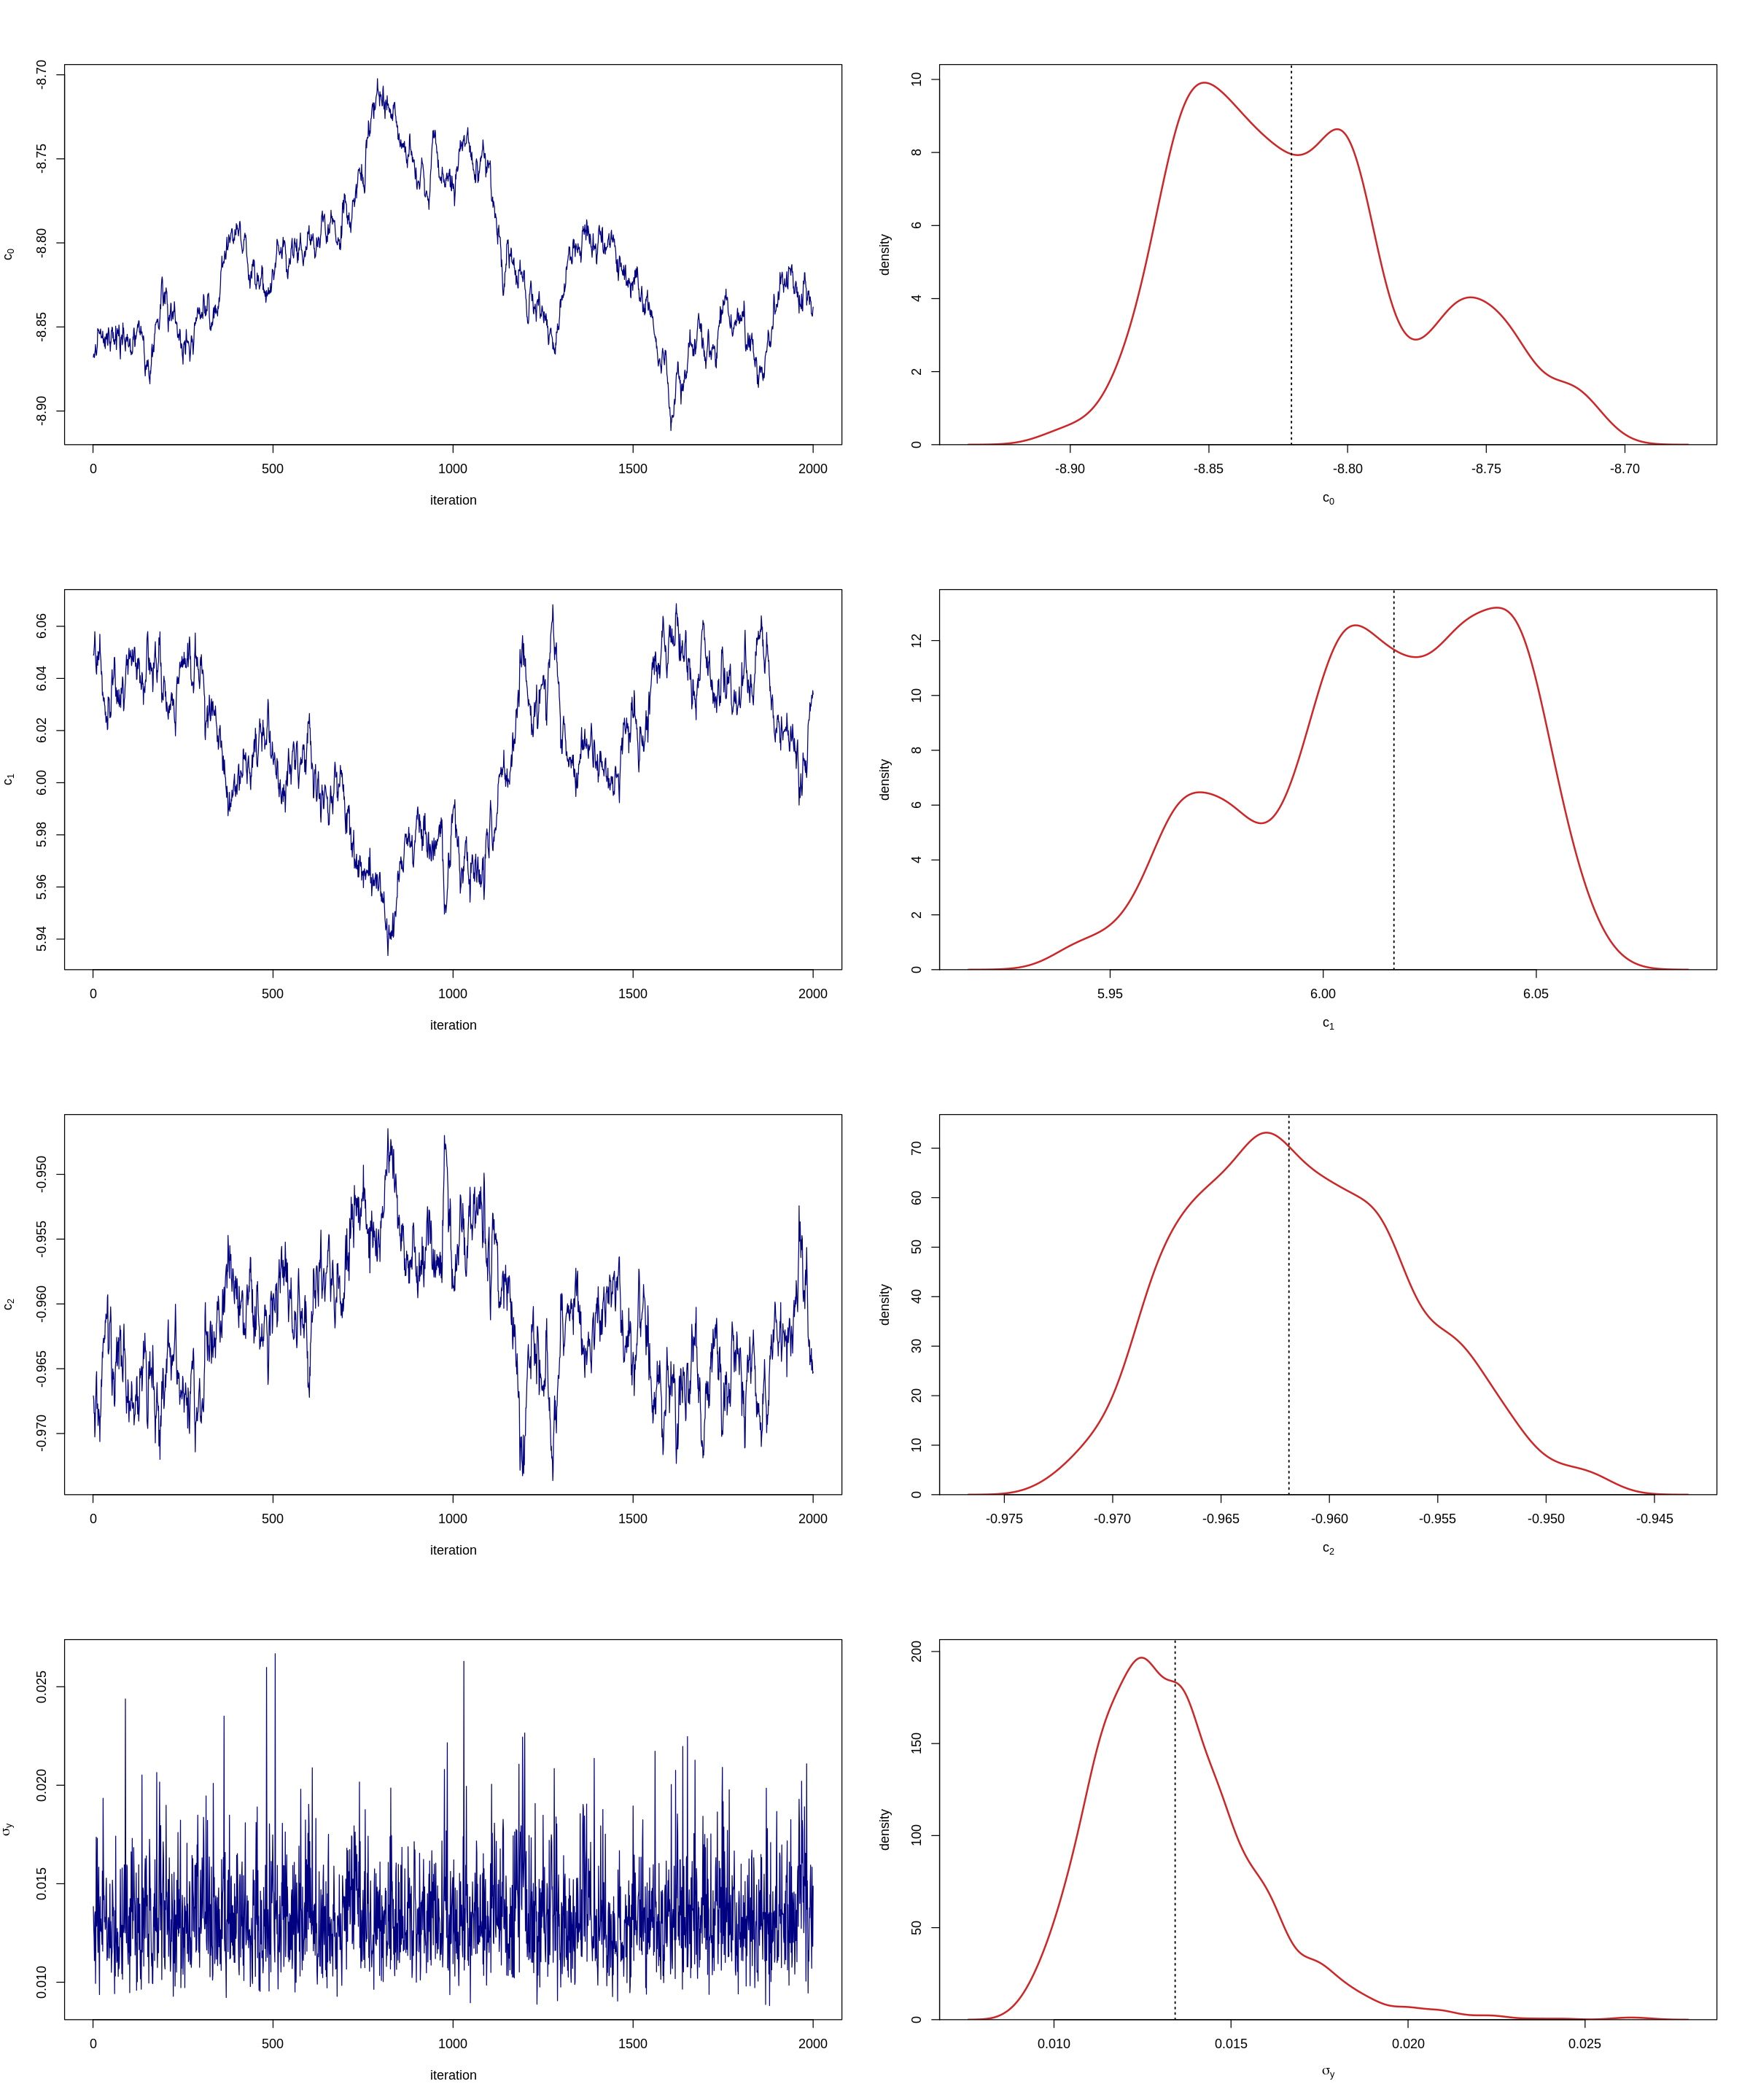

In [22]:
thetas.mean <- NULL

# Plot MCMC chains and use density estimation to plot 1D posterior PDFs from these.
par(mfrow=c(4,2), cex=0.9) #,mar=c(3.0,3.5,0.5,0.5), oma=0.5*c(1,1,1,1), mgp=c(1.8,0.6,0), cex=0.9)
options(repr.plot.width=20, repr.plot.height=24)
parnames <- c(expression(c[0]), expression(paste(c[1])), expression(c[2]), expression(sigma[y]))
for (j in 3:6) { # columns of postSamp
    plot(1:nrow(m.results.filtered), m.results.filtered[,j], 
         type="l", col="navy",
         xlab="iteration", ylab=parnames[j-2])
    
    d.theta      <- density(m.results.filtered[,j], n=2^10)
    x.theta.mean <- compute.mean(d.theta$x, d.theta$y)
    thetas.mean  <- c(thetas.mean, x.theta.mean)
    
    
    plot(d.theta$x, d.theta$y, 
         type="l", lwd=2, col="firebrick3",
         yaxs="i", 
         ylim=1.05*c(0,max(d.theta$y)), 
         xlab=parnames[j-2], ylab="density")
    abline(v=x.theta.mean,, lwd=1.5, lty=3)
}

**Study of correlation**

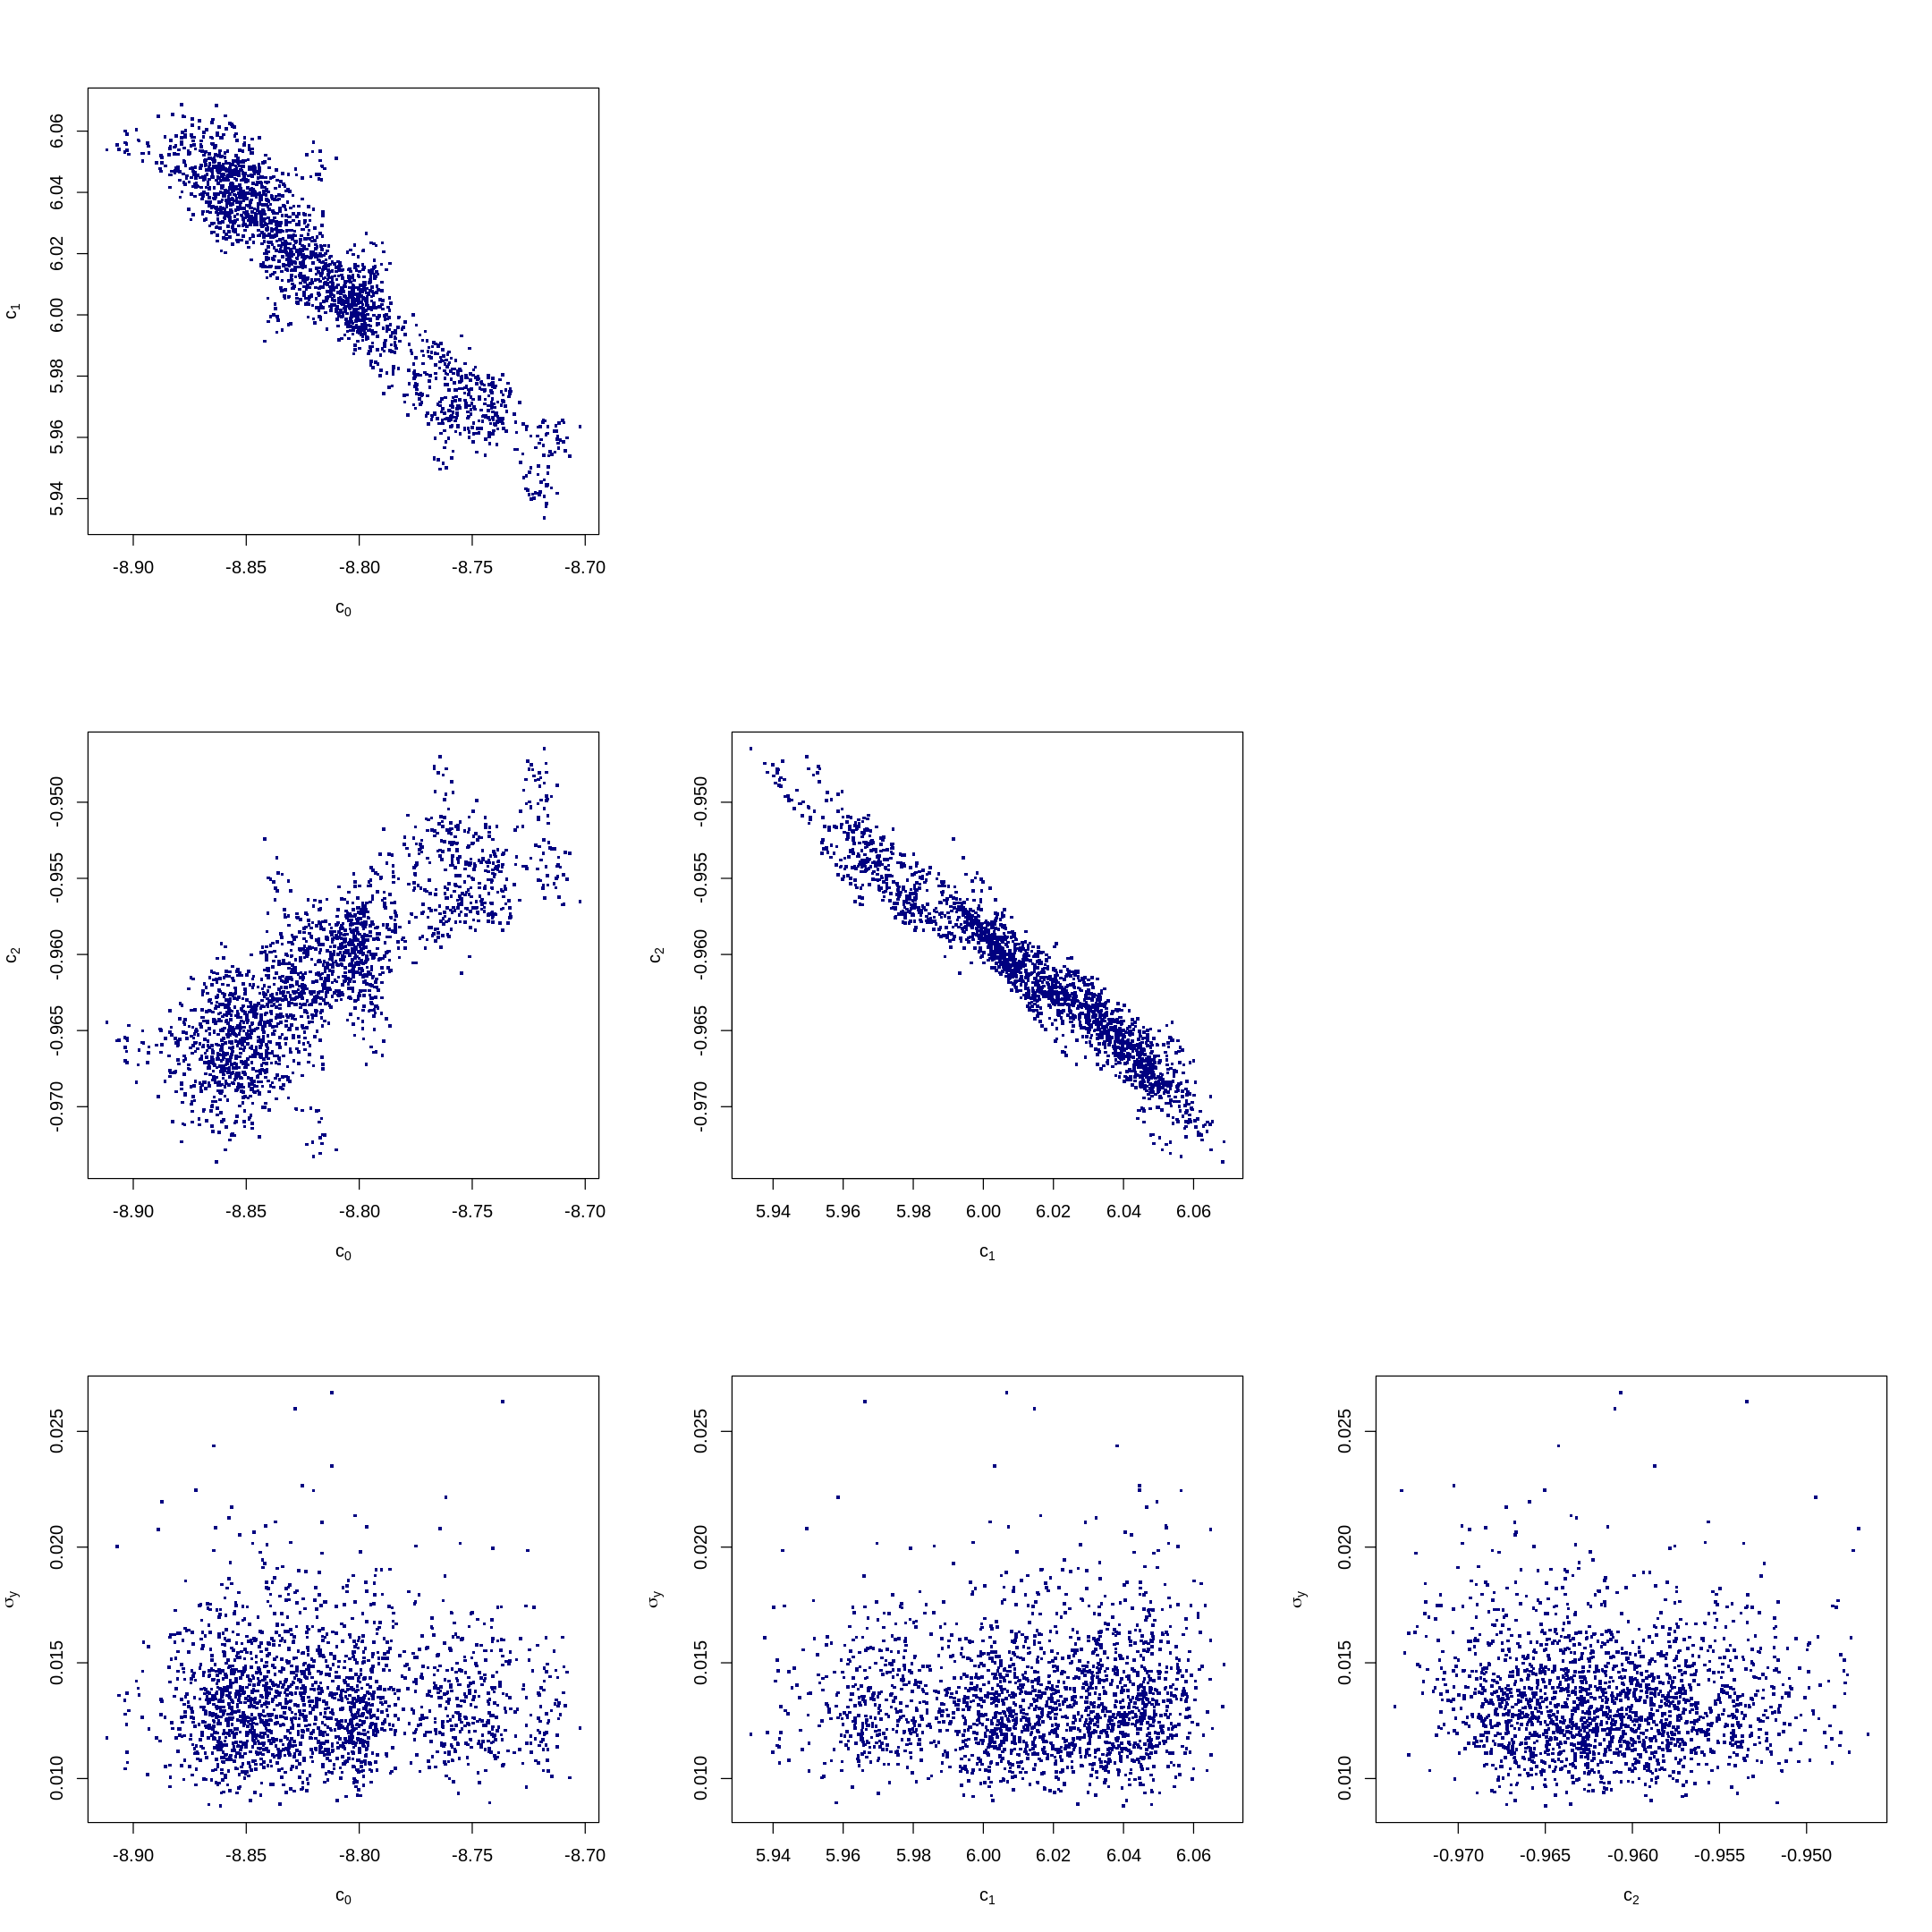

In [23]:
par(mfcol=c(3,3), cex=1)
options(repr.plot.width=18, repr.plot.height=18)
for(i in 1:3) {
    for(j in 2:4) {
        if(j<=i) {
            plot.new()
        } else {
            plot(m.results.filtered[,i+2], 
                 m.results.filtered[,j+2], 
                 xlab=parnames[i], ylab=parnames[j], 
                 pch=".", cex=3, col="navy")
        }
    }
}

### 1.2. - Markov Chain Monte Carlo to predict peak height measurements at $x_1=2.8 \ \mathrm{mm}$ and $x_2=2.6 \ \mathrm{mm}$ <a class="anchor" id="Ex1.2."></a>

**Plot of measurements and prediction curve**

In [24]:
m.results.filtered.MAP <- which.max(m.results.filtered[,1] + m.results.filtered[,2])
theta.most.prob.MAP    <- m.results.filtered[m.results.filtered.MAP, 3:6]

In [25]:
x.pred     <- seq(2, 4, length.out=2001)
y.pred     <- quadratic.model(x.pred, theta.most.prob.MAP[1], theta.most.prob.MAP[2], theta.most.prob.MAP[3])

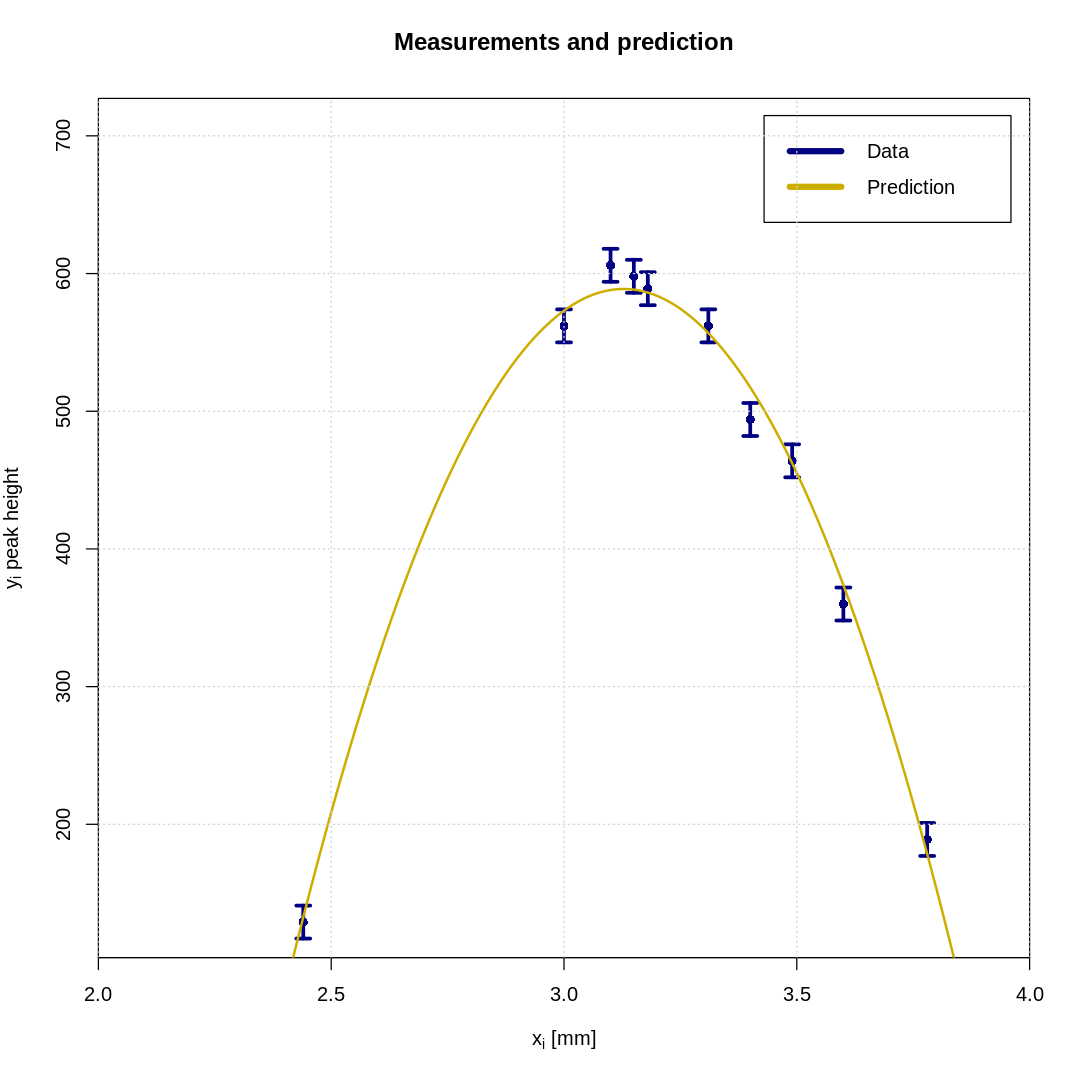

In [26]:
options(repr.plot.width=9, repr.plot.height=9)
errbar(x.i, y.i*1000,
       (y.i + theta.most.prob.MAP[4])*1000, (y.i - theta.most.prob.MAP[4])*1000,
       xaxs='i', yaxs='i', col='navy', errbar.col="navy",
       type='p', lty=1, lwd=3,
       xlim=c(2,4),
       ylim=c(0.8*min(y.i),1.2*max(y.i))*1000, 
       xlab=expression(paste(x[i], " [mm]")),
       ylab=expression(paste(y[i], " peak height")))
lines(x.pred, y.pred*1000, col='gold3', lwd=2)
legend("topright",
       inset=0.02, 
       legend=c("Data", "Prediction"),
       col=c("navy", "gold3"), 
       lty=1:1, 
       cex=1,
       box.lty=1,
       lwd=5)
title("Measurements and prediction", line=2)
grid()

**Prediction at $x_1=2.8 \ \mathrm{mm}$ using indirect method**

In [27]:
mod.pred.x.1 <- cbind(m.results.filtered[,3], m.results.filtered[,4], m.results.filtered[,5]) %*% t(cbind(1, 2.8, 2.8^2))

In [28]:
like.samp.x.1 <- rnorm(n=length(mod.pred.x.1), mean=mod.pred.x.1, sd=m.results.filtered[,6])
like.den.x.1  <- density(like.samp.x.1, n=2^10)

In [29]:
y.pred.ind.x.1 <- c(like.den.x.1$x[which.max(like.den.x.1$y)], 
                    quantile(like.samp.x.1, probs=c(pnorm(-1), pnorm(+1)), names=FALSE))

In [30]:
cat("Prediction at x1=2.8mm :", y.pred.ind.x.1[1]*1000)

Prediction at x1=2.8mm : 486.1128

**Prediction at $x_2=2.6 \ \mathrm{mm}$ using indirect method**

In [31]:
mod.pred.x.2 <- cbind(m.results.filtered[,3], m.results.filtered[,4], m.results.filtered[,5]) %*% t(cbind(1, 2.6, 2.6^2))

In [32]:
like.samp.x.2 <- rnorm(n=length(mod.pred.x.2), mean=mod.pred.x.2, sd=m.results.filtered[,6])
like.den.x.2  <- density(like.samp.x.2, n=2^10)

In [33]:
y.pred.ind.x.2 <- c(like.den.x.2$x[which.max(like.den.x.2$y)], 
                    quantile(like.samp.x.2, probs=c(pnorm(-1), pnorm(+1)), names=FALSE))

In [34]:
cat("Prediction at x2=2.6mm :", y.pred.ind.x.2[1]*1000)

Prediction at x2=2.6mm : 317.4677

**Plot with new predictions**

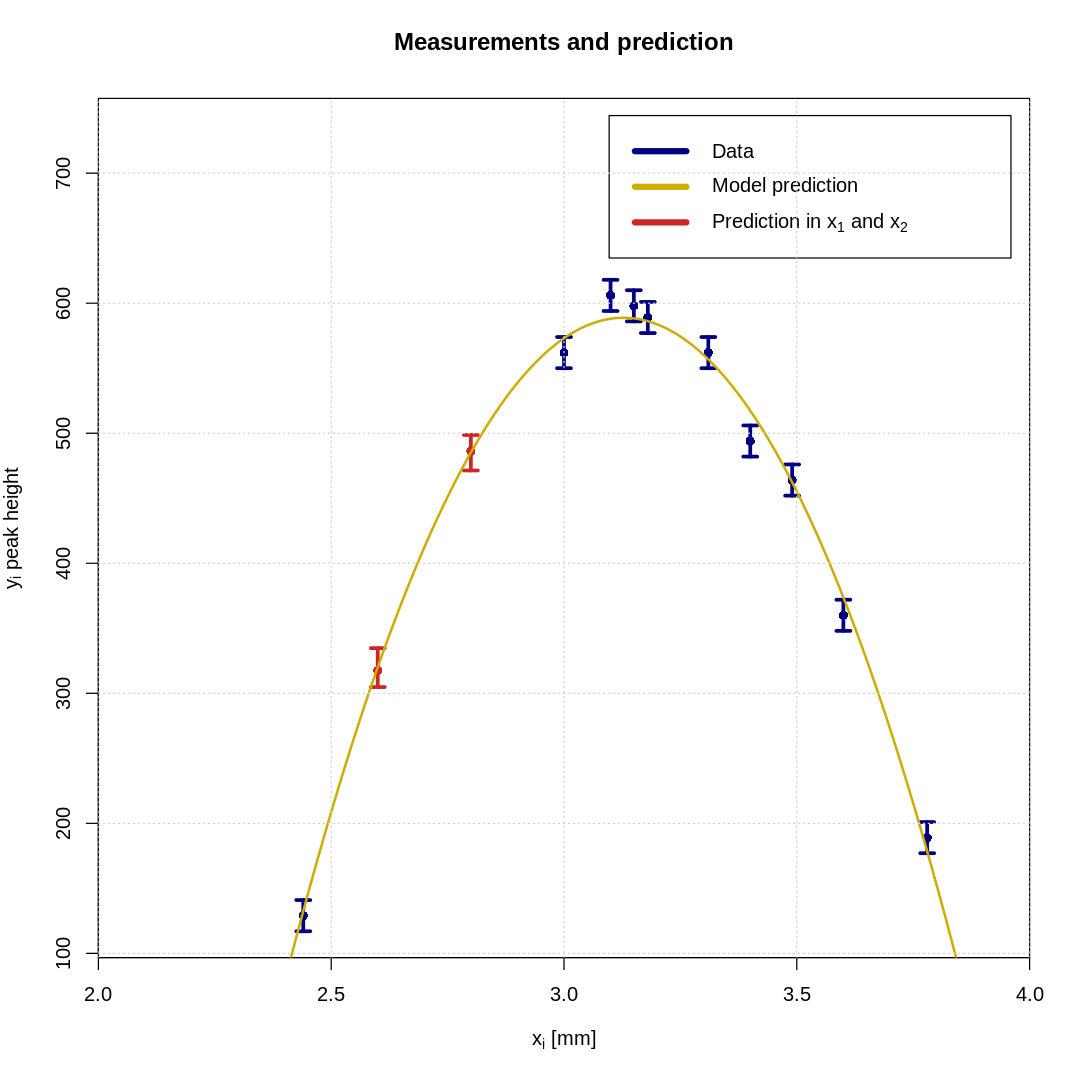

In [35]:
options(repr.plot.width=9, repr.plot.height=9)
errbar(x.i, y.i*1000,
       (y.i + theta.most.prob.MAP[4])*1000, (y.i - theta.most.prob.MAP[4])*1000,
       xaxs='i', yaxs='i', col='navy', errbar.col="navy",
       type='p', lty=1, lwd=3,
       xlim=c(2,4),
       ylim=c(0.75*min(y.i),1.25*max(y.i))*1000, 
       xlab=expression(paste(x[i], " [mm]")),
       ylab=expression(paste(y[i], " peak height")))
errbar(c(2.8,2.6), c(y.pred.ind.x.1[1],y.pred.ind.x.2[1])*1000, 
       c(y.pred.ind.x.1[3], y.pred.ind.x.2[3])*1000, c(y.pred.ind.x.1[2], y.pred.ind.x.2[2])*1000,
       col="firebrick3", errbar.col="firebrick3", 
       lwd=3, type="p", add=TRUE)
lines (x.pred, y.pred*1000, 
       col='gold3', lwd=2)
legend("topright",
       inset=0.02, 
       legend=c("Data", "Model prediction", expression(paste("Prediction in ", x[1], " and ", x[2]))),
       col=c("navy", "gold3", "firebrick3"), 
       lty=1:1, 
       cex=1,
       box.lty=1,
       lwd=5)
title("Measurements and prediction", line=2)
grid()

***
## Exercise 2 <a class="anchor" id="Ex2."></a>
* [Index](#ExI)
***

**Load data in a proper format for the needed libraries**

In [36]:
data   <- NULL
data$D <- c(4, 5, 4, 1, 0, 4, 3, 4, 0, 6, 3, 3, 4, 0,
            2, 6, 3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5,
            3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 1, 1,
            1, 1, 1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1,
            0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
            0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 2, 3, 1, 1,
            2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 0, 1, 4, 0,
            0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0)
data$N <- 112
years  <- 1851:1962

**Visualize the data set**

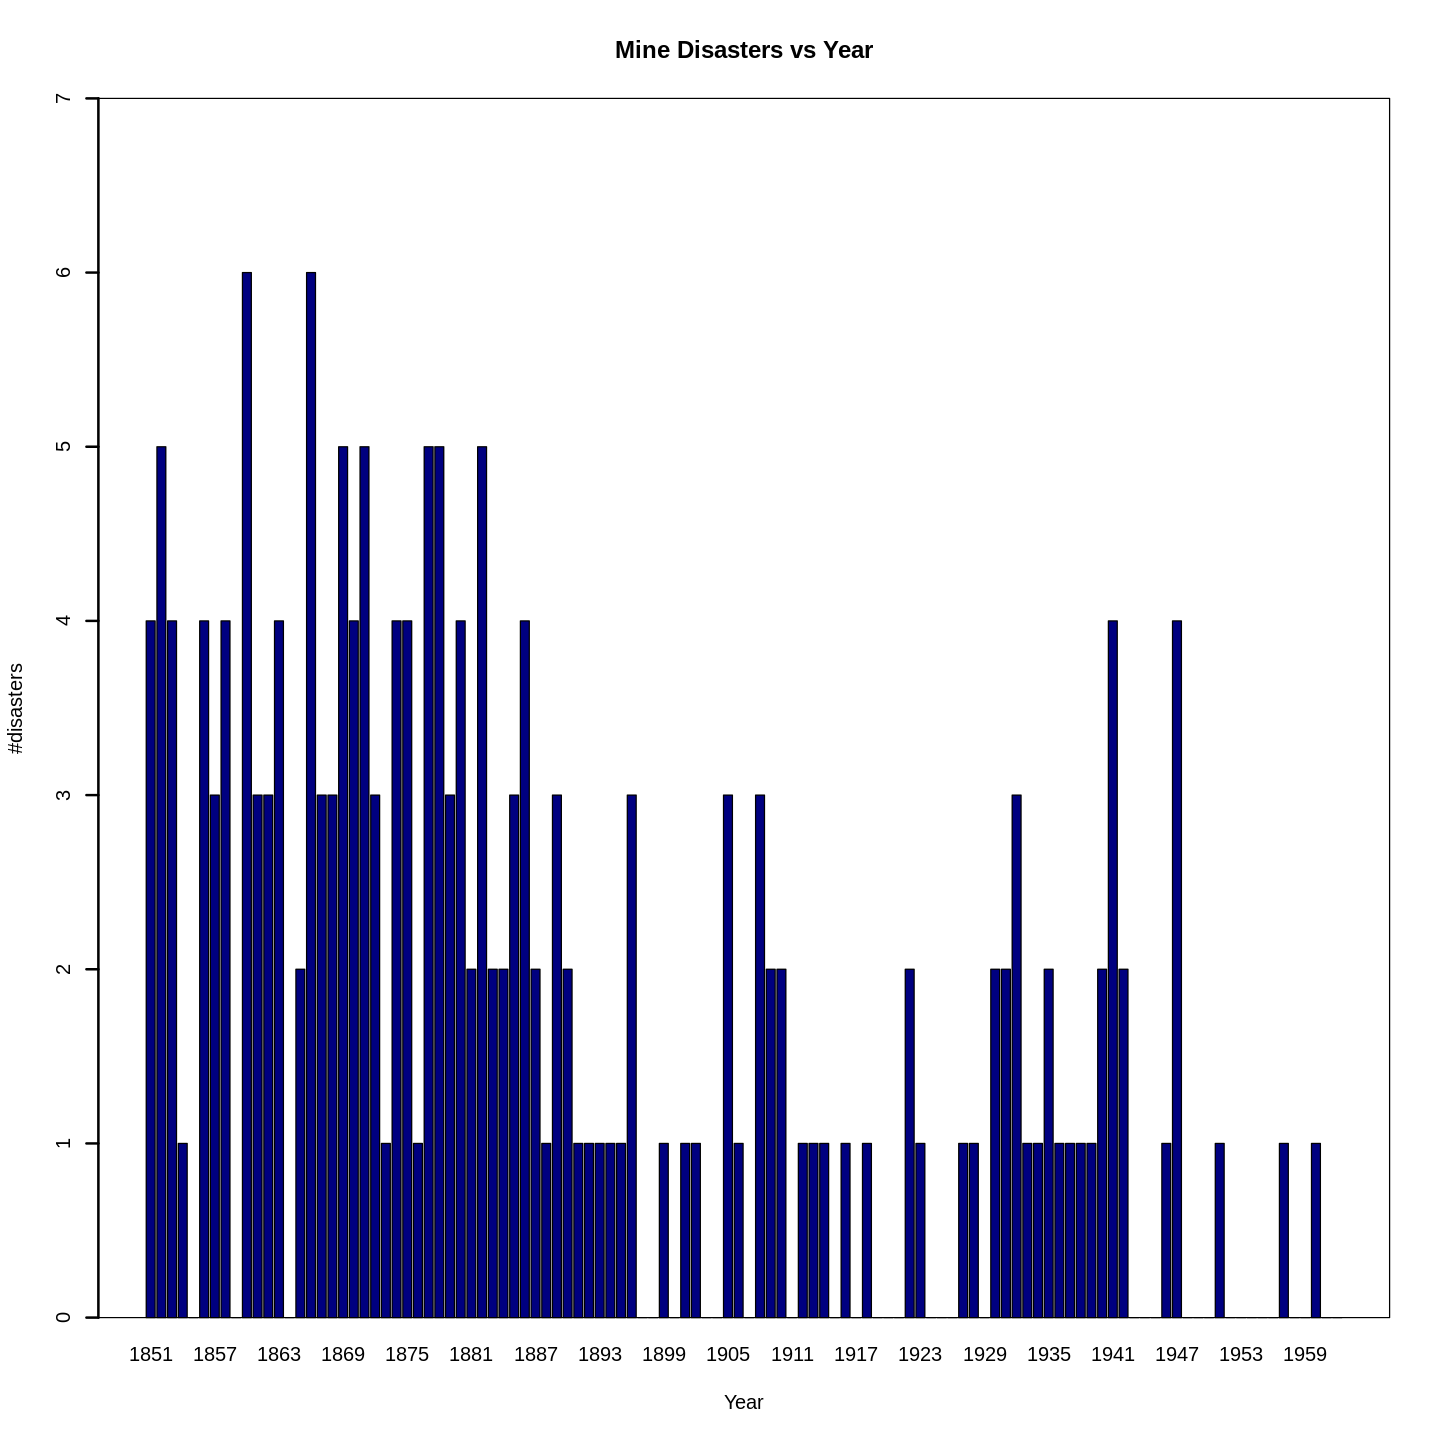

In [37]:
options(repr.plot.width=12, repr.plot.height=12)
barplot(data$D, names.arg=years,
        xlab="Year", ylab=expression("#disasters"),
        ylim=c(0,7),
        lwd=2, col="navy",
        main="Mine Disasters vs Year")
box()

### 2.1. - Implementation of the model in ```jags``` and inference of the parameters $b_0$, $b_1$ and $\tau$ <a class="anchor" id="Ex2.1."></a>

**Define the model using BUGS language. Consider that:**

* **$y_t \sim \text{Pois}(\mu_t)$**
* **$p(y_t|\mu_t) = \frac{\mu_t^{y_t}}{y_t!} e^{-\mu_t}$**

In [38]:
cat("model{
    # data likelihood
    for (t in 1:N) { 
        log(mu[t]) <- b0 + b1*step(t-tau)

        D[t] ~ dpois(mu[t])
        y[t] ~ dpois(mu[t])
    }

    # uniform prior in (-3,+3) for b0 and b1, in (1,N) for tau
    b0~dunif(-3,3)
    b1~dunif(-3,3)
    tau~dunif(1,N) 
}", file="BUGS_model.bug")

**Assign the following initial parameters:**

$$
\boxed{
b_0 = 0\\
b_1 = 0\\
\tau = 50
}
$$

**and run BUGS model**

In [39]:
model <- "BUGS_model.bug"

In [40]:
init.par     <- NULL
init.par$b0  <- 0
init.par$b1  <- 0
init.par$tau <- 50

In [41]:
jags.m  <- jags.model(model, data, init.par, n.adapt=0)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model



In [42]:
# Update the Markov chain (Burn-in)
update(jags.m, 1000)

In [43]:
chain.0 <- coda.samples(jags.m , c("b0", "b1","tau"), n.iter=10000)

NOTE: Stopping adaptation




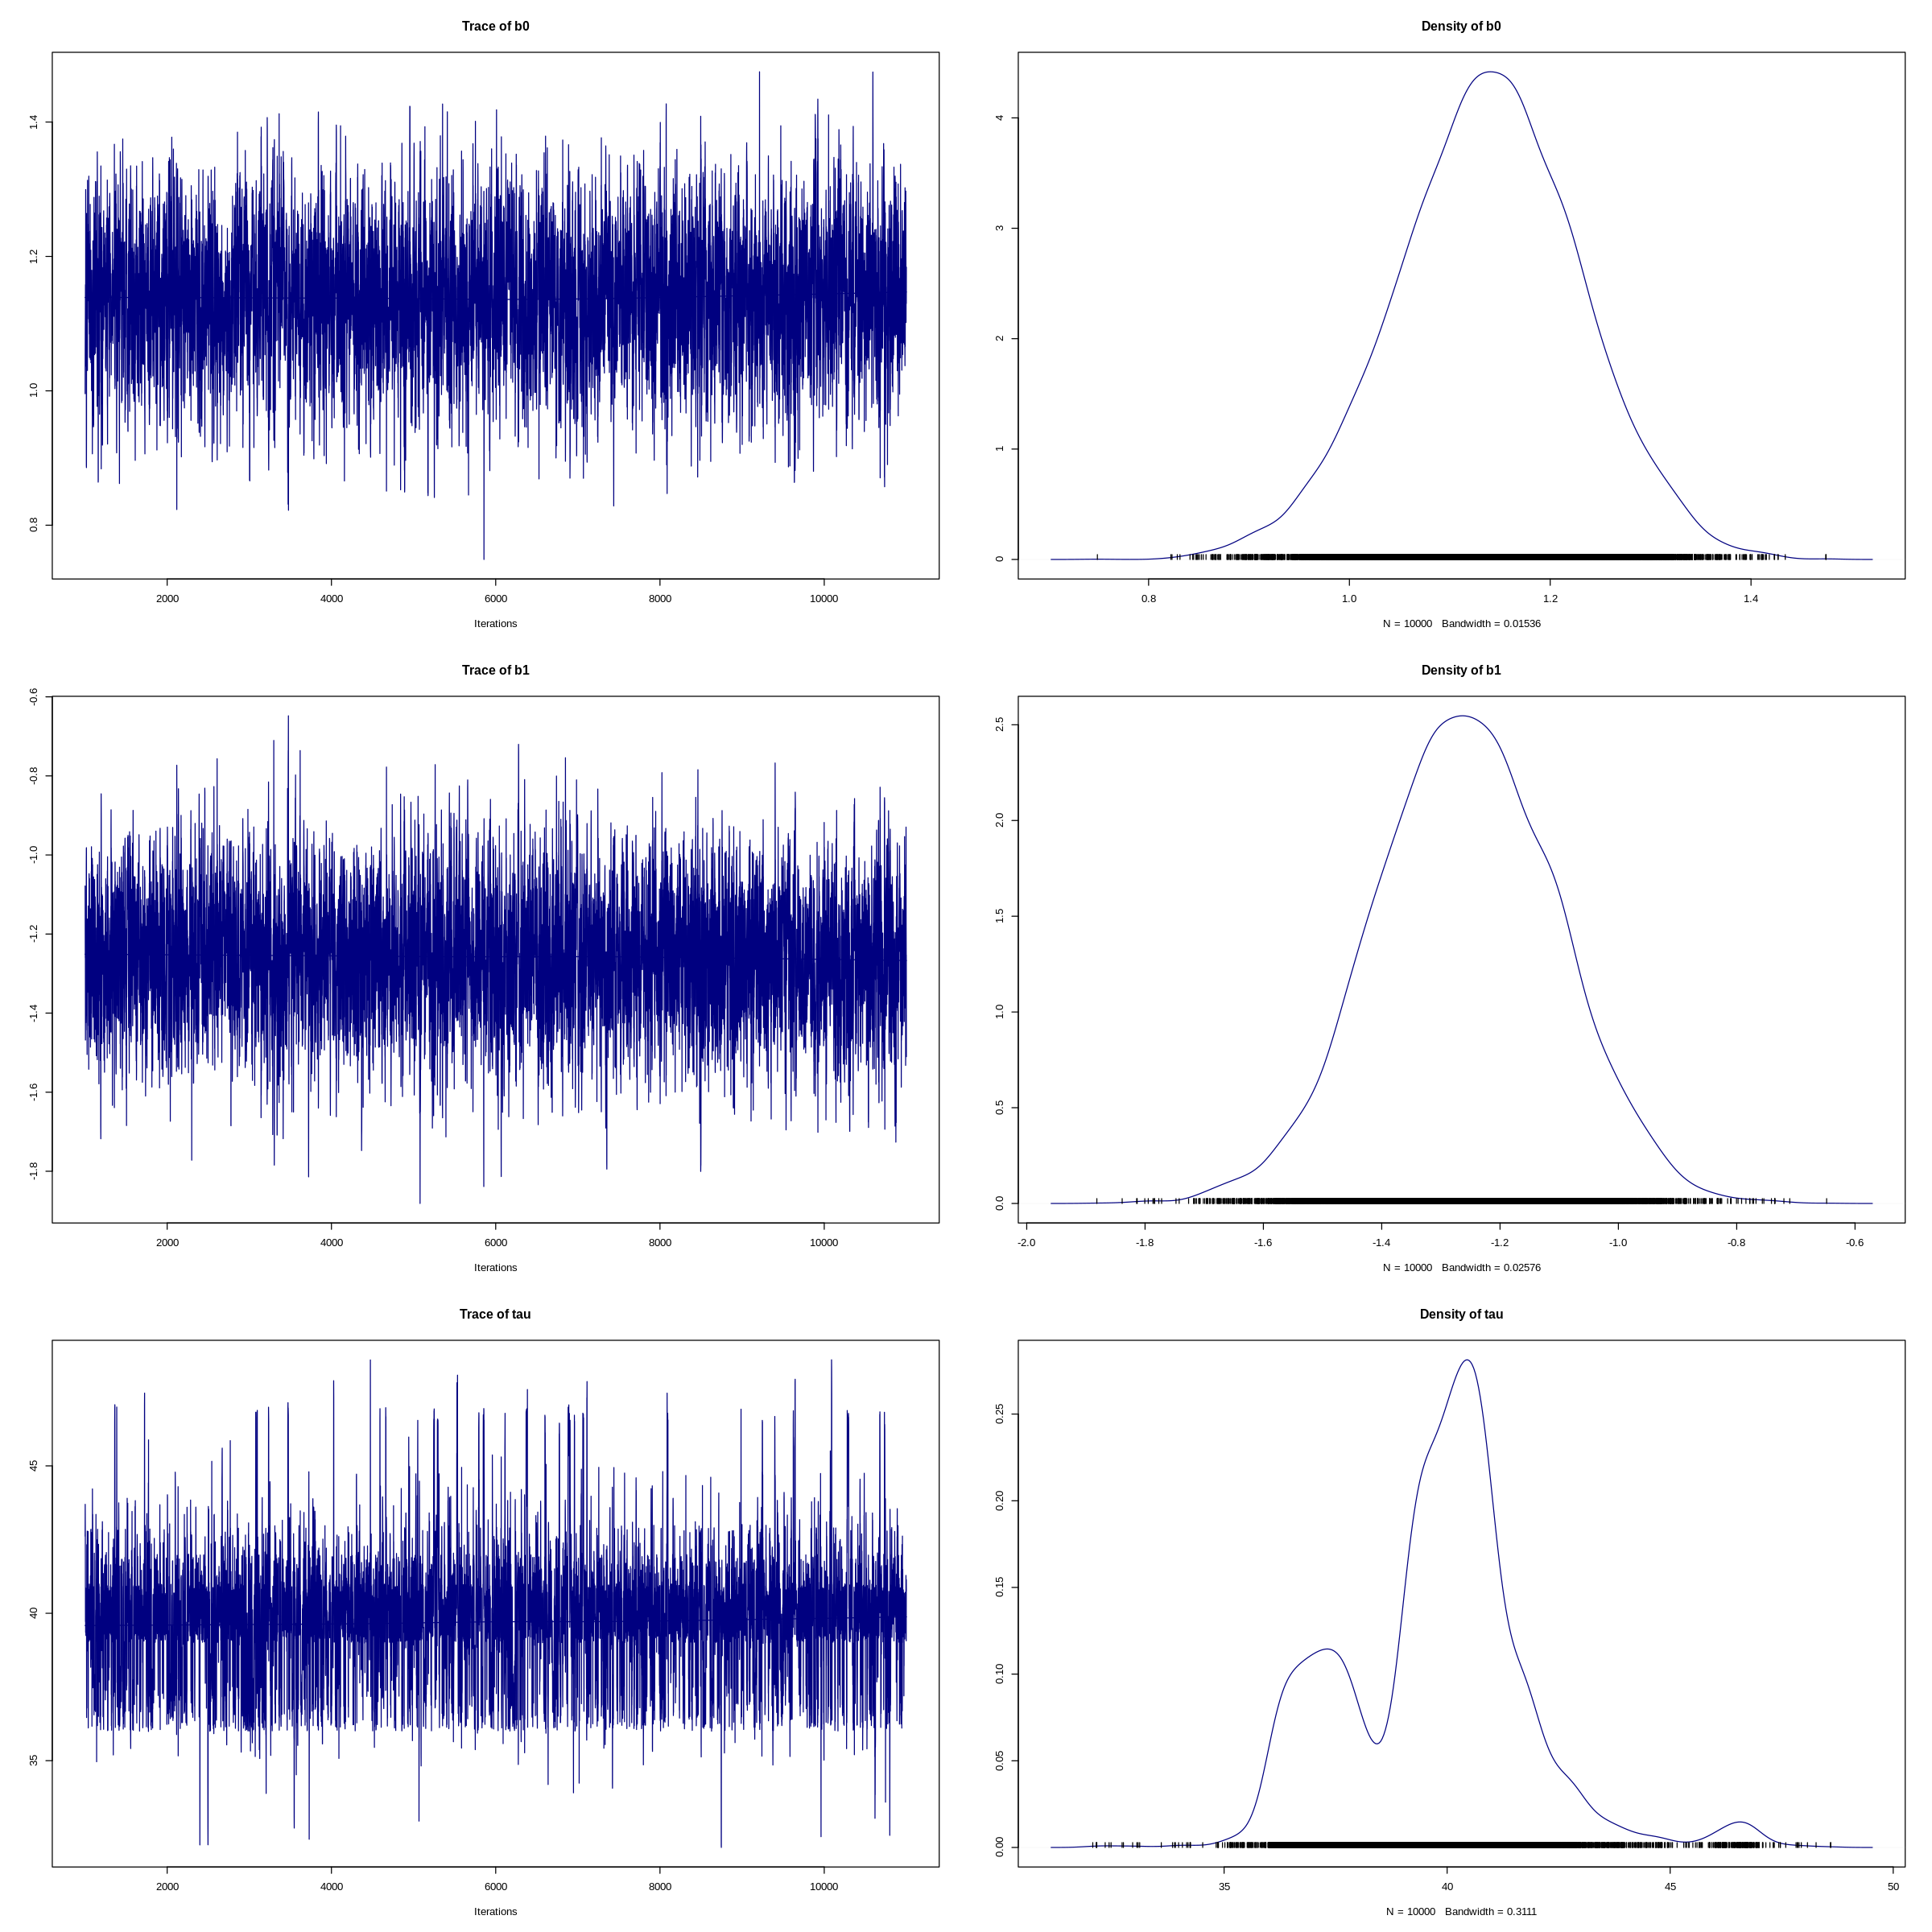

In [44]:
par(cex=1)
options(repr.plot.width=20, repr.plot.height=20)
plot(chain.0, col="navy")

### 2.2. - Features of the chains and effects of the burn-in and thinning <a class="anchor" id="Ex2.2."></a>

**Format the chain in a better way**

In [45]:
chain.0.df <- as.data.frame(as.mcmc(chain.0))

**Summary of the chain**

In [46]:
summary(chain.0)


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD  Naive SE Time-series SE
b0   1.138 0.09216 0.0009216       0.001771
b1  -1.258 0.15334 0.0015334       0.002762
tau 39.744 2.07220 0.0207220       0.048996

2. Quantiles for each variable:

       2.5%    25%    50%    75%   97.5%
b0   0.9519  1.078  1.139  1.200  1.3170
b1  -1.5623 -1.361 -1.259 -1.153 -0.9591
tau 36.1362 38.343 39.960 40.824 44.3186


**Study of correlation**

In [47]:
cat("Correlation matrix:\n\n")
print(cor(chain.0.df))

Correlation matrix:

            b0          b1         tau
b0   1.0000000 -0.55832060 -0.24141797
b1  -0.5583206  1.00000000 -0.02889761
tau -0.2414180 -0.02889761  1.00000000


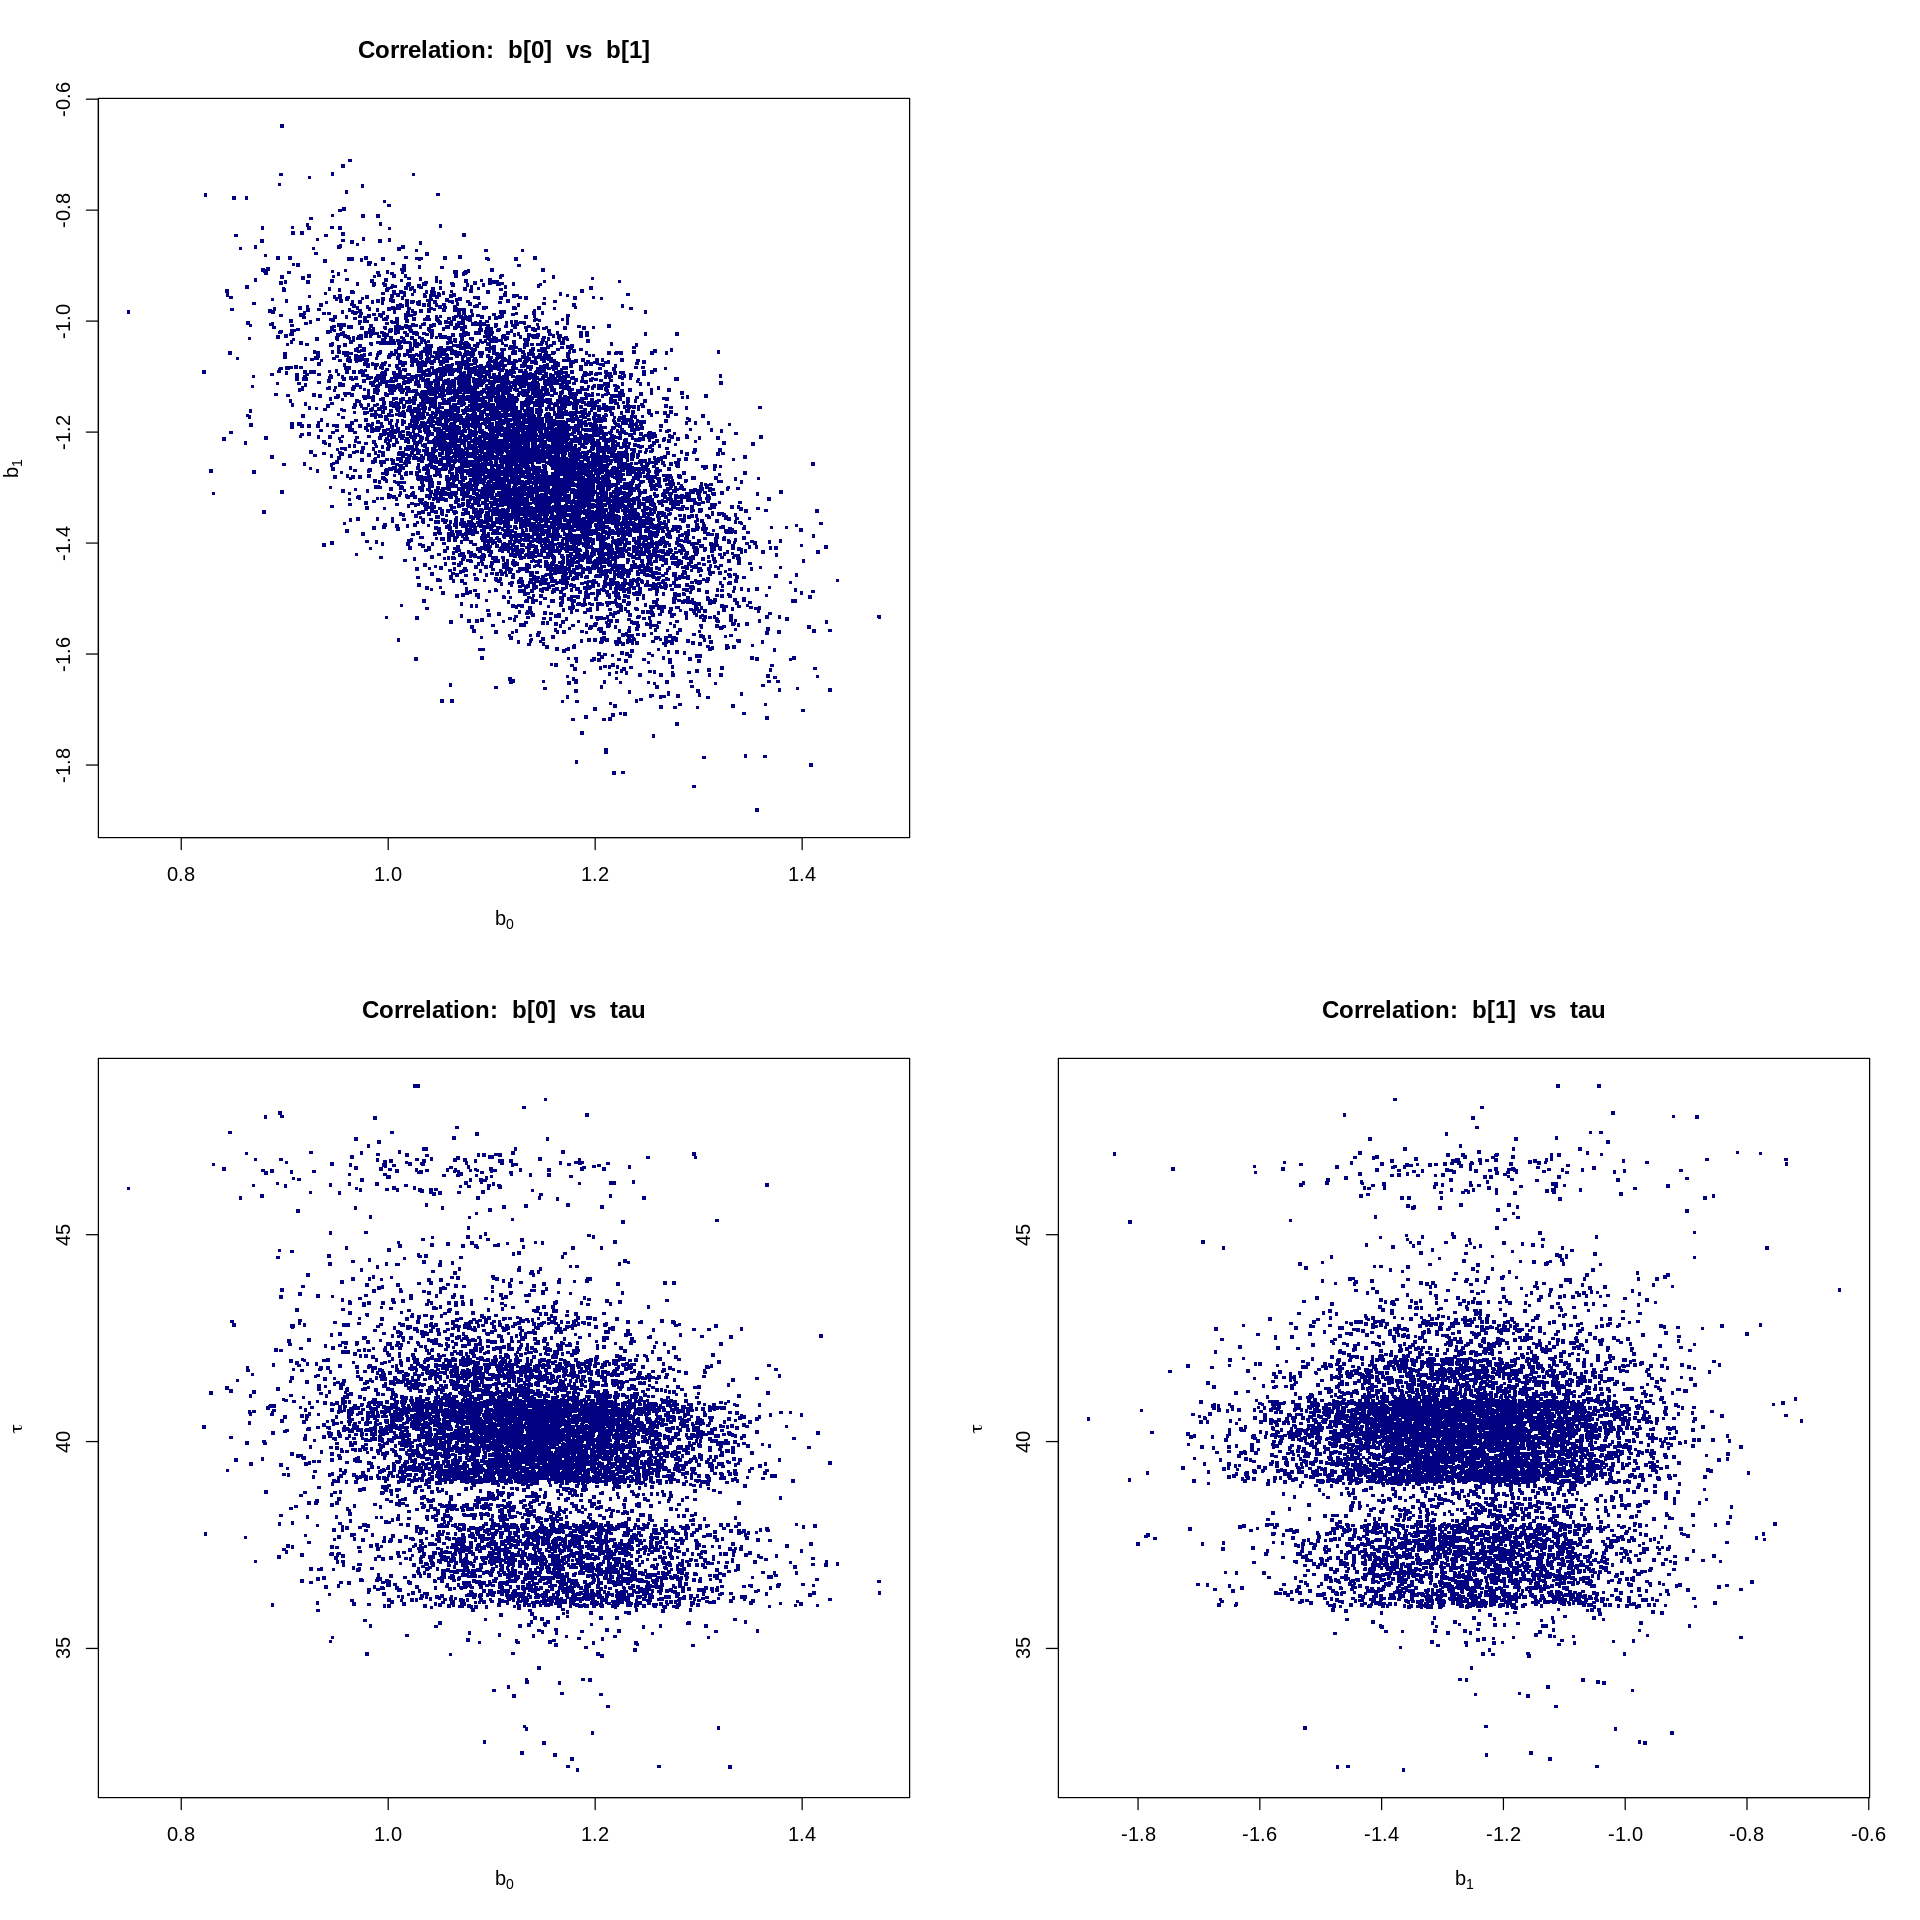

In [48]:
parnames <- c(expression(b[0]), expression(b[1]), expression(tau))
par(mfcol=c(2,2), cex=1)
options(repr.plot.width=16, repr.plot.height=16)
for(i in 1:2) {
    for(j in 2:3) {
        if(j<=i) {
            plot.new()
        } else {
            plot(chain.0.df[[i]], 
                 chain.0.df[[j]], 
                 xlab=parnames[i], ylab=parnames[j], 
                 pch=".", cex=3, col="navy",
                 main=paste("Correlation: ", parnames[i], " vs ", parnames[j]))
        }
    }
}

**Effects of the burn-in**

In [49]:
burn.ins <- c(1, 250, 500, 1000, 1500, 2500)

In [50]:
b0.burn.in  <- NULL
b1.burn.in  <- NULL
tau.burn.in <- NULL

In [51]:
# autocorrelations
b0.burn.in.ac  <- NULL
b1.burn.in.ac  <- NULL
tau.burn.in.ac <- NULL

In [52]:
for (burn.in in burn.ins) {
    model <- "BUGS_model.bug"
    
    # initialize parameters
    init.par     <- NULL
    init.par$b0  <- 0
    init.par$b1  <- 0
    init.par$tau <- 50
    
    # initialize BUGS model with a certain burn in
    jags.m  <- jags.model(model, data, init.par, n.adapt=0)
    
    # Update the Markov chain (Burn-in)
    update(jags.m, burn.in)
    
    # run BUGS model
    chain.0 <- coda.samples(jags.m , c("b0", "b1","tau"), n.iter=10000, thin=1)
    
    # convert to data.frame
    chain.0.df <- as.data.frame(as.mcmc(chain.0))
    
    # store results for every cycle of the loop
    b0.burn.in  <- cbind(b0.burn.in,  chain.0.df[[1]])
    b1.burn.in  <- cbind(b1.burn.in,  chain.0.df[[2]])
    tau.burn.in <- cbind(tau.burn.in, chain.0.df[[3]])
    
    b0.burn.in.ac  <- cbind(b0.burn.in.ac,  autocorr(as.mcmc(chain.0.df[1]), lags=seq(0,50,1)))
    b1.burn.in.ac  <- cbind(b1.burn.in.ac,  autocorr(as.mcmc(chain.0.df[2]), lags=seq(0,50,1)))
    tau.burn.in.ac <- cbind(tau.burn.in.ac, autocorr(as.mcmc(chain.0.df[3]), lags=seq(0,50,1)))
}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

NOTE: Stopping adaptation


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

NOTE: Stopping adaptation


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

NOTE: Stopping adaptation


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

NOTE: Stopping adaptation


Compiling model graph
   Resolving undeclare

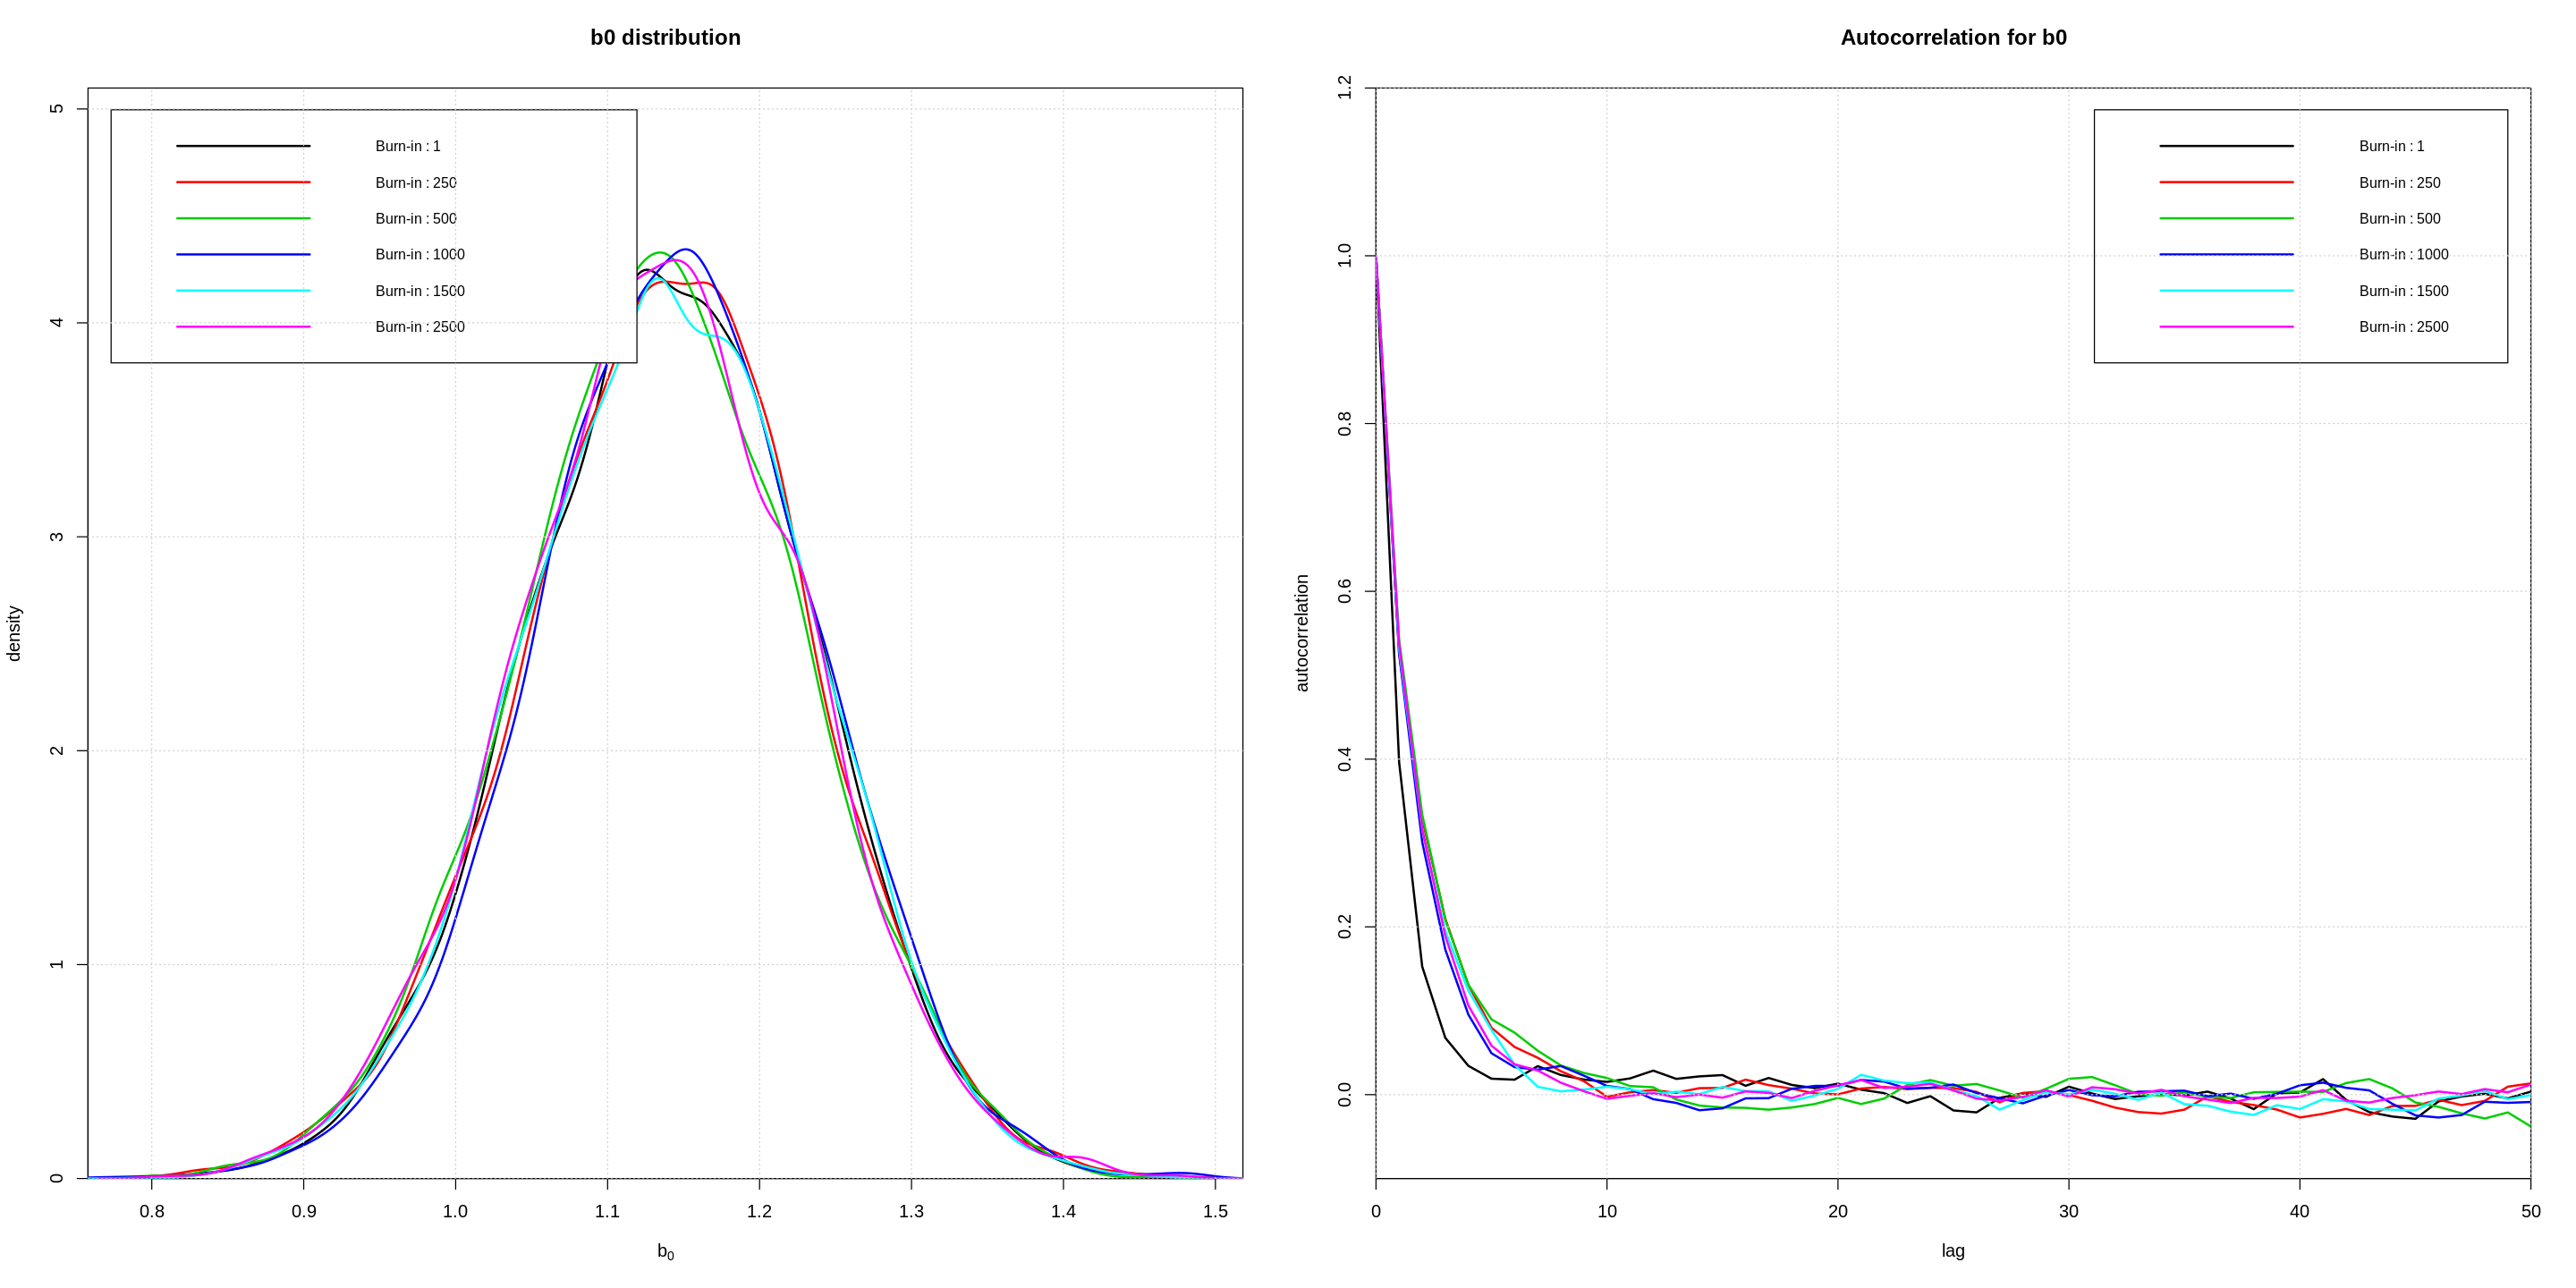

In [53]:
par(mfrow=c(1,2), cex=1)
options(repr.plot.width=24, repr.plot.height=12)
for (i in 1:length(burn.ins)) {
    d.b0 <- density(b0.burn.in[,i])
    if (i==1) {
        plot(d.b0$x, d.b0$y,
             xaxs='i', yaxs='i', col=i,
             type='l', lty=1, lwd=2,
             ylim=c(0,1.2*max(d.b0$y)), 
             xlab=expression(b[0]),
             ylab="density")
    } else {
        lines(d.b0$x, d.b0$y,
             col=i, type='l', lty=1, lwd=2)
    }
}
legend("topleft", 
       inset=0.02, 
       legend=paste0(rep("Burn-in : ", length(burn.ins)), as.character(burn.ins)),
       col=c(1:length(burn.ins)), 
       lty=1:1, 
       cex=0.8,
       text.width=0.15,
       box.lty=1,
       lwd=2)
title("b0 distribution", line=2)
grid()

for (i in 1:length(burn.ins)) {
    ac.b0 <- b0.burn.in.ac[,i]
    if (i==1) {
        plot(c(0:50), ac.b0,
             xaxs='i', yaxs='i', col=i,
             type='l', lty=1, lwd=2,
             ylim=c(-0.1,1.2*max(ac.b0)), 
             xlab=expression(lag),
             ylab=expression(autocorrelation))
    } else {
        lines(c(0:50), ac.b0,
             col=i, type='l', lty=1, lwd=2)
    }
}
legend("topright",
       inset=0.02, 
       legend=paste0(rep("Burn-in : ", length(burn.ins)), as.character(burn.ins)),
       col=c(1:length(burn.ins)),
       lty=1, 
       cex=0.8,
       text.width=5,
       box.lty=1,
       lwd=2)
title("Autocorrelation for b0", line=2)
grid()

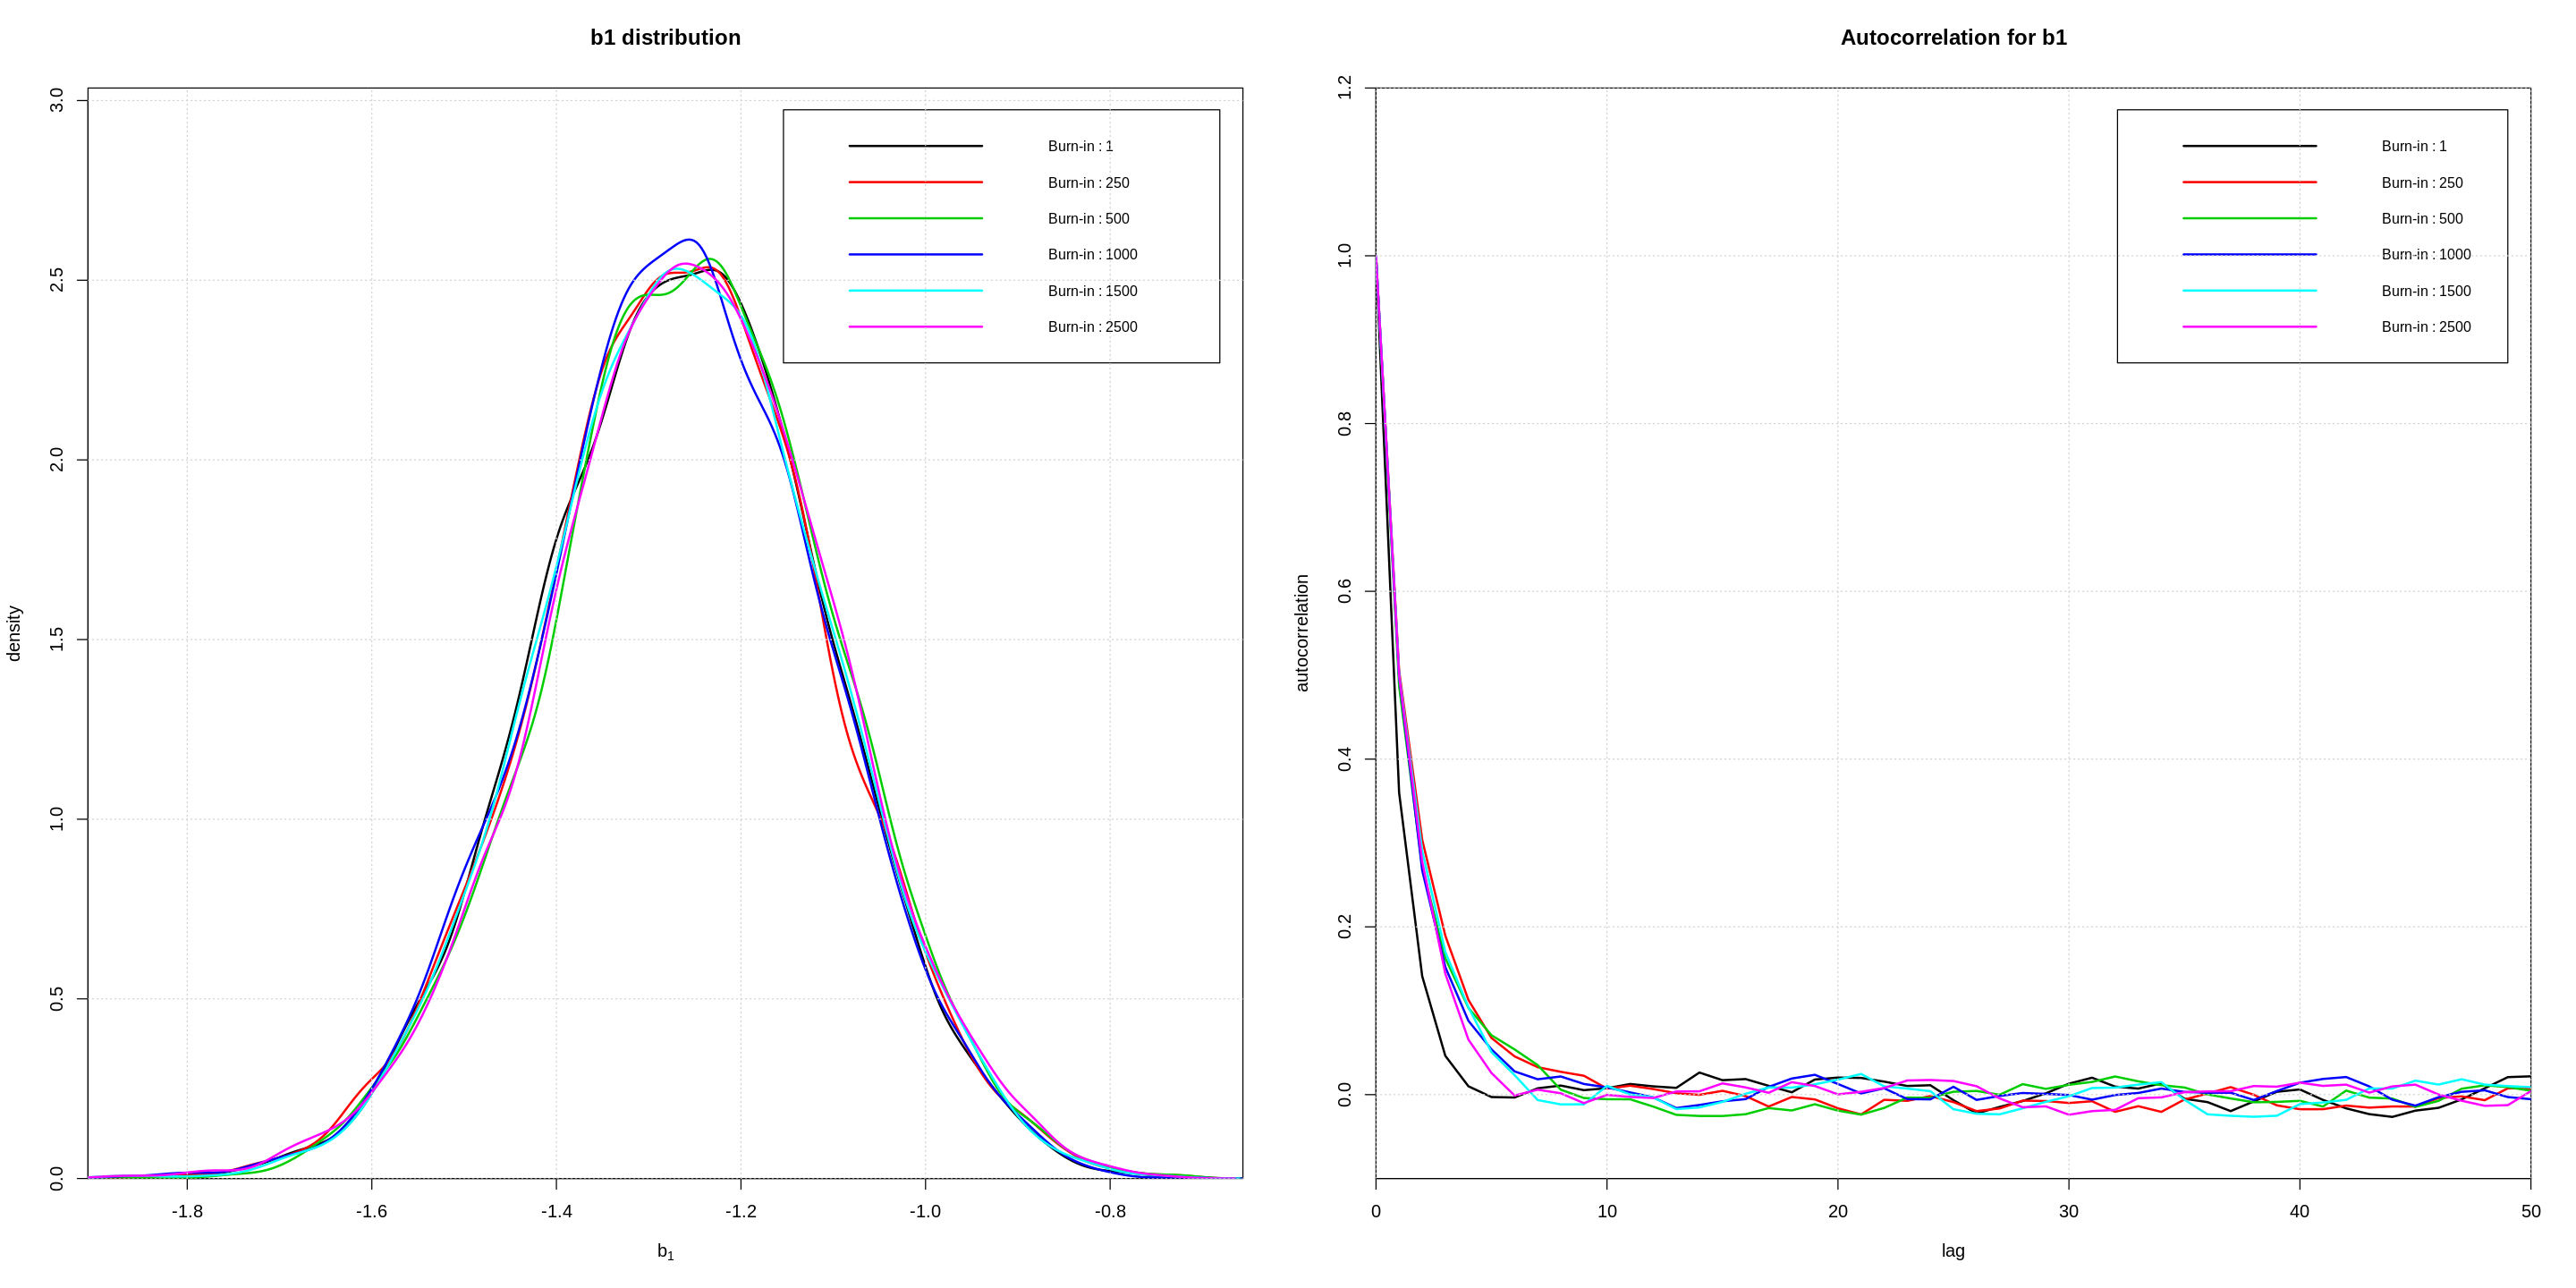

In [54]:
par(mfrow=c(1,2), cex=1)
options(repr.plot.width=24, repr.plot.height=12)
for (i in 1:length(burn.ins)) {
    d.b1 <- density(b1.burn.in[,i])
    if (i==1) {
        plot(d.b1$x, d.b1$y,
             xaxs='i', yaxs='i', col=i,
             type='l', lty=1, lwd=2,
             ylim=c(0,1.2*max(d.b1$y)), 
             xlab=expression(b[1]),
             ylab="density")
    } else {
        lines(d.b1$x, d.b1$y,
             col=i, type='l', lty=1, lwd=2)
    }
}
legend("topright",
       inset=0.02, 
       legend=paste0(rep("Burn-in : ", length(burn.ins)), as.character(burn.ins)),
       col=c(1:length(burn.ins)), 
       lty=1:1, 
       cex=0.8,
       text.width=0.15,
       box.lty=1,
       lwd=2)
title("b1 distribution", line=2)
grid()

for (i in 1:length(burn.ins)) {
    ac.b1 <- b1.burn.in.ac[,i]
    if (i==1) {
        plot(c(0:50), ac.b1,
             xaxs='i', yaxs='i', col=i,
             type='l', lty=1, lwd=2,
             ylim=c(-0.1,1.2*max(ac.b1)), 
             xlab=expression(lag),
             ylab=expression(autocorrelation))
    } else {
        lines(c(0:50), ac.b1,
             col=i, type='l', lty=1, lwd=2)
    }
}
legend("topright",
       inset=0.02, 
       legend=paste0(rep("Burn-in : ", length(burn.ins)), as.character(burn.ins)),
       col=c(1:length(burn.ins)), 
       lty=1, 
       cex=0.8,
       text.width=4,
       box.lty=1,
       lwd=2)
title("Autocorrelation for b1", line=2)
grid()

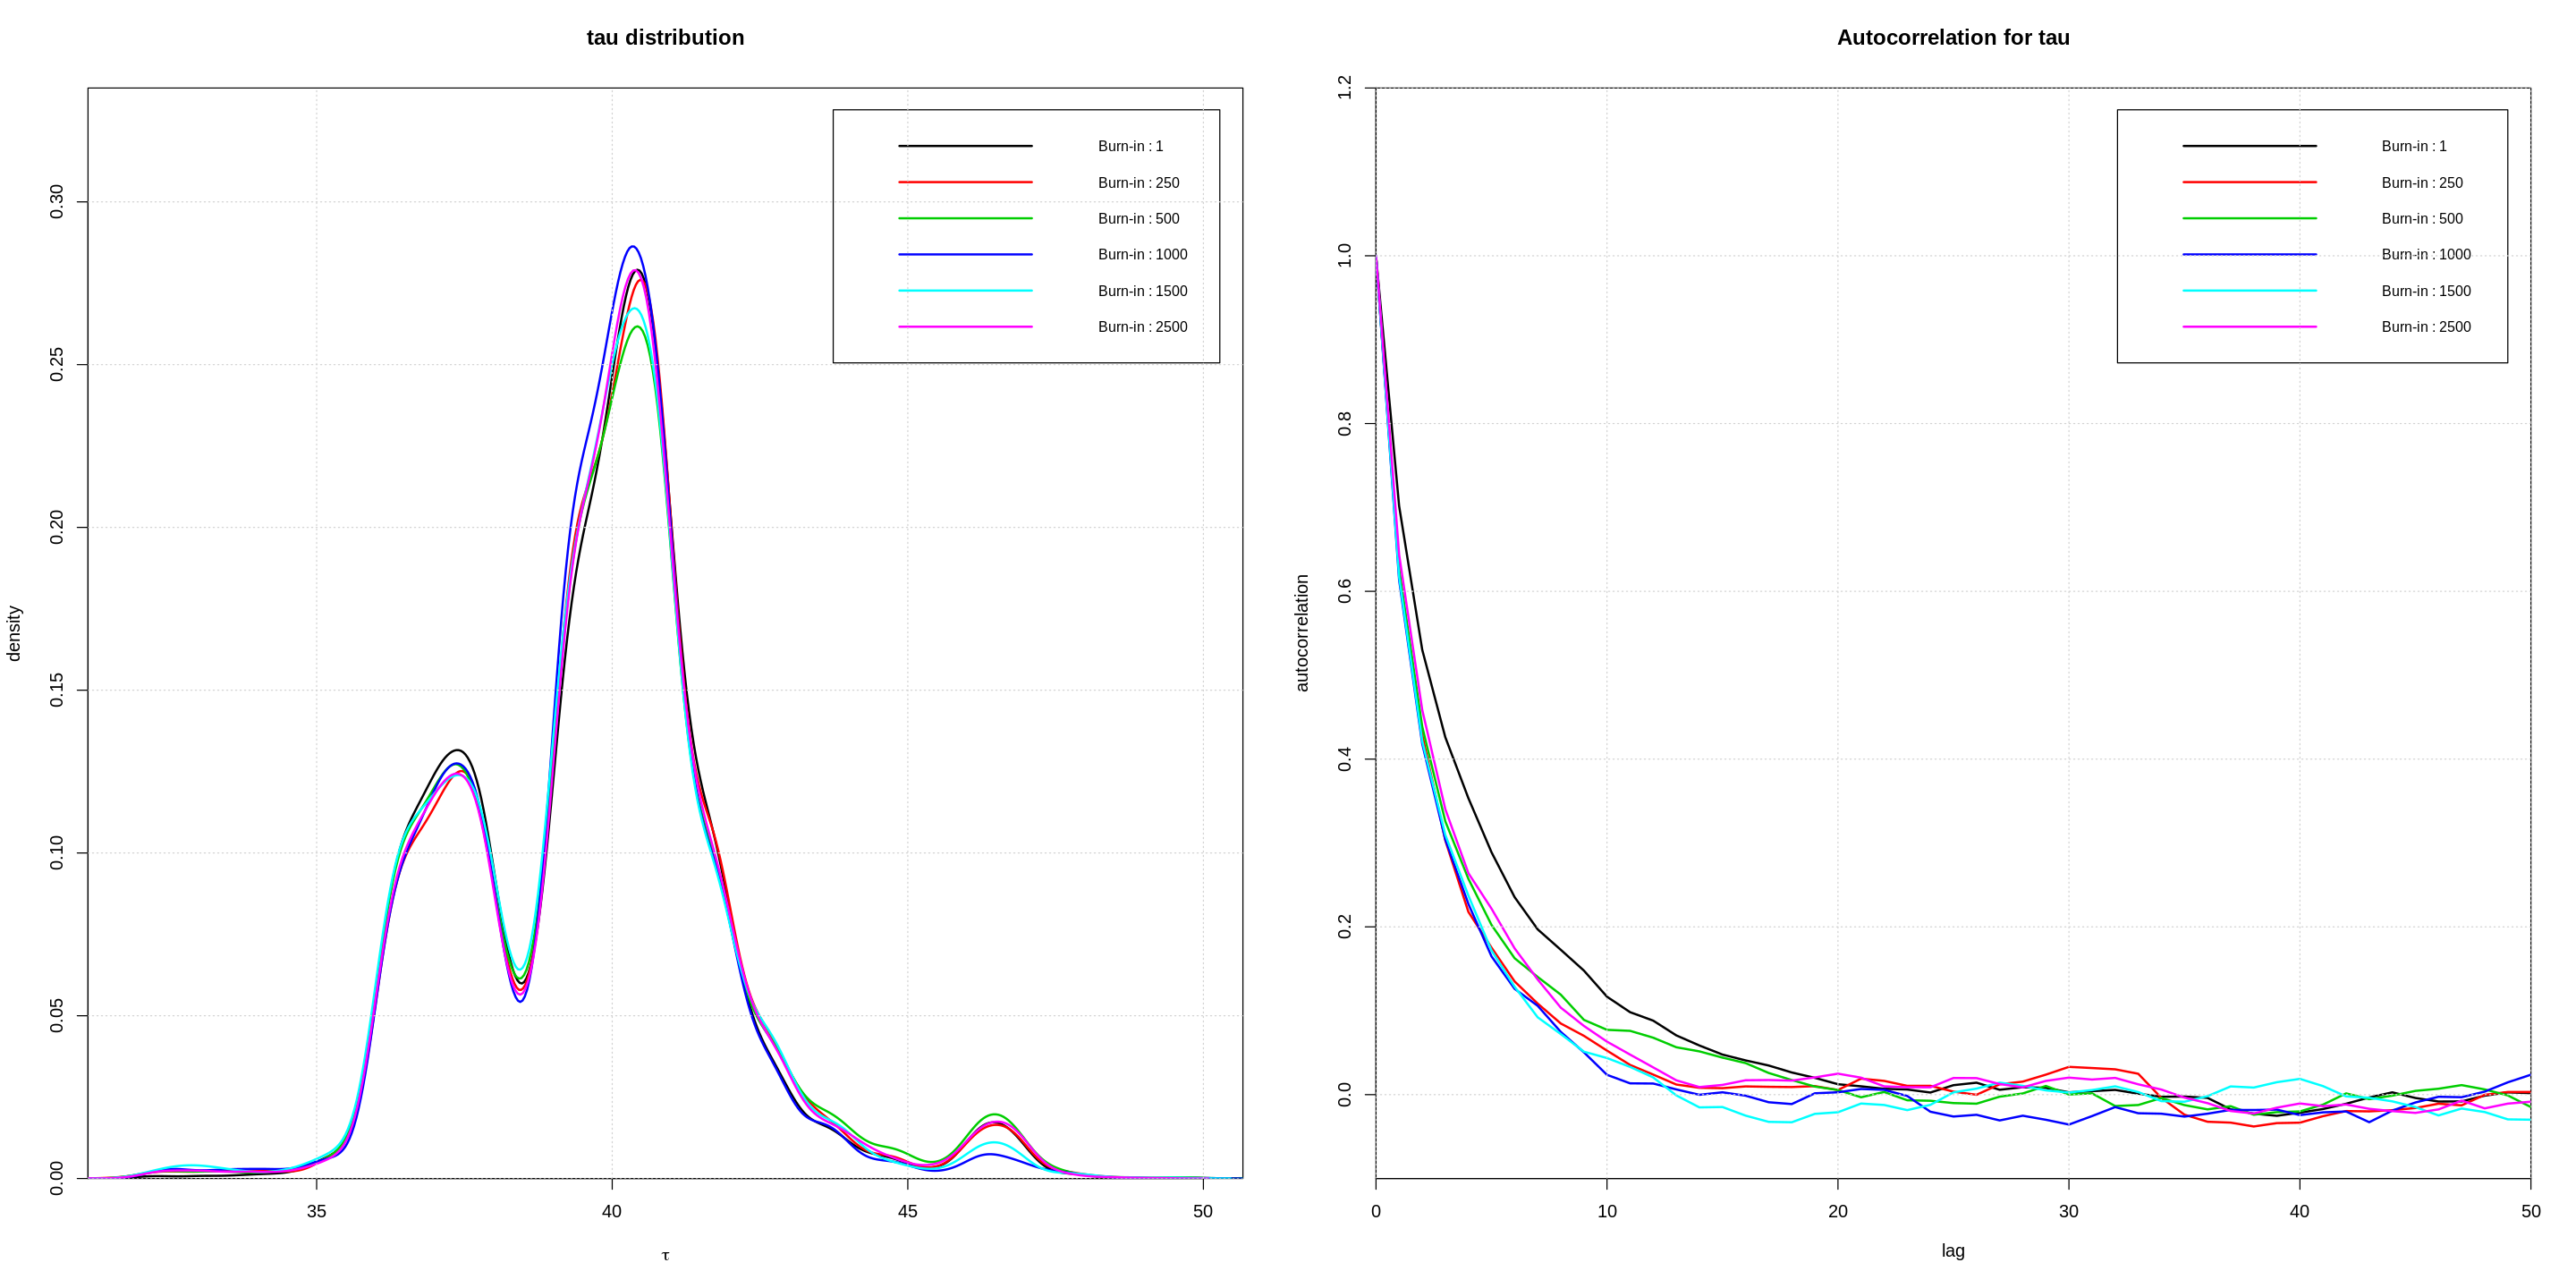

In [55]:
par(mfrow=c(1,2), cex=1)
options(repr.plot.width=24, repr.plot.height=12)
for (i in 1:length(burn.ins)) {
    d.tau <- density(tau.burn.in[,i])
    if (i==1) {
        plot(d.tau$x, d.tau$y,
             xaxs='i', yaxs='i', col=i,
             type='l', lty=1, lwd=2,
             ylim=c(0,1.2*max(d.tau$y)), 
             xlab=expression(tau),
             ylab="density")
    } else {
        lines(d.tau$x, d.tau$y,
             col=i, type='l', lty=1, lwd=2)
    }
}
legend("topright",
       inset=0.02, 
       legend=paste0(rep("Burn-in : ", length(burn.ins)), as.character(burn.ins)),
       col=c(1:length(burn.ins)), 
       lty=1, 
       cex=0.8,
       text.width=1.5,
       box.lty=1,
       lwd=2)
title("tau distribution", line=2)
grid()

for (i in 1:length(burn.ins)) {
    ac.tau <- tau.burn.in.ac[,i]
    if (i==1) {
        plot(c(0:50), ac.tau,
             xaxs='i', yaxs='i', col=i,
             type='l', lty=1, lwd=2,
             ylim=c(-0.1,1.2*max(ac.tau)), 
             xlab=expression(lag),
             ylab=expression(autocorrelation))
    } else {
        lines(c(0:50), ac.tau,
             col=i, type='l', lty=1, lwd=2)
    }
}
legend("topright",
       inset=0.02, 
       legend=paste0(rep("Burn-in : ", length(burn.ins)), as.character(burn.ins)),
       col=c(1:length(burn.ins)), 
       lty=1:1, 
       cex=0.8,
       text.width=4,
       box.lty=1,
       lwd=2)
title("Autocorrelation for tau", line=2)
grid()

**As it is possible to see from the previous plots, the burn-in does not influence significantly the results. This behaviour is due to the fact that the parameters are initialized to good values.**

**Effects of the thinning**

In [56]:
thinnings <- c(1, 2, 5, 10, 25, 50)

In [57]:
b0.thinnings  <- NULL
b1.thinnings  <- NULL
tau.thinnings <- NULL

In [58]:
# autocorrelations
b0.thinnings.ac  <- NULL
b1.thinnings.ac  <- NULL
tau.thinnings.ac <- NULL

In [59]:
for (thinning in thinnings) {
    model <- "BUGS_model.bug"
    
    # initialize parameters
    init.par     <- NULL
    init.par$b0  <- 0
    init.par$b1  <- 0
    init.par$tau <- 50
    
    # initialize BUGS model with a certain burn in
    jags.m  <- jags.model(model, data, init.par, n.adapt=0)
    
    # Update the Markov chain (Burn-in)
    update(jags.m, burn.in)
    
    # run BUGS model
    chain.0 <- coda.samples(jags.m , c("b0", "b1","tau"), thin=thinning, n.iter=10000)
    
    # convert to data.frame
    chain.0.df <- as.data.frame(as.mcmc(chain.0))
    
    # store results for every cycle of the loop
    b0.thinnings  <- cbind(b0.thinnings,  chain.0.df[[1]])
    b1.thinnings  <- cbind(b1.thinnings,  chain.0.df[[2]])
    tau.thinnings <- cbind(tau.thinnings, chain.0.df[[3]])
    
    b0.thinnings.ac  <- cbind(b0.thinnings.ac,  autocorr(as.mcmc(chain.0.df[1]), lags=seq(0,50,1)))
    b1.thinnings.ac  <- cbind(b1.thinnings.ac,  autocorr(as.mcmc(chain.0.df[2]), lags=seq(0,50,1)))
    tau.thinnings.ac <- cbind(tau.thinnings.ac, autocorr(as.mcmc(chain.0.df[3]), lags=seq(0,50,1)))
}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

NOTE: Stopping adaptation


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

NOTE: Stopping adaptation


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

NOTE: Stopping adaptation


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

NOTE: Stopping adaptation


Compiling model graph
   Resolving undeclare

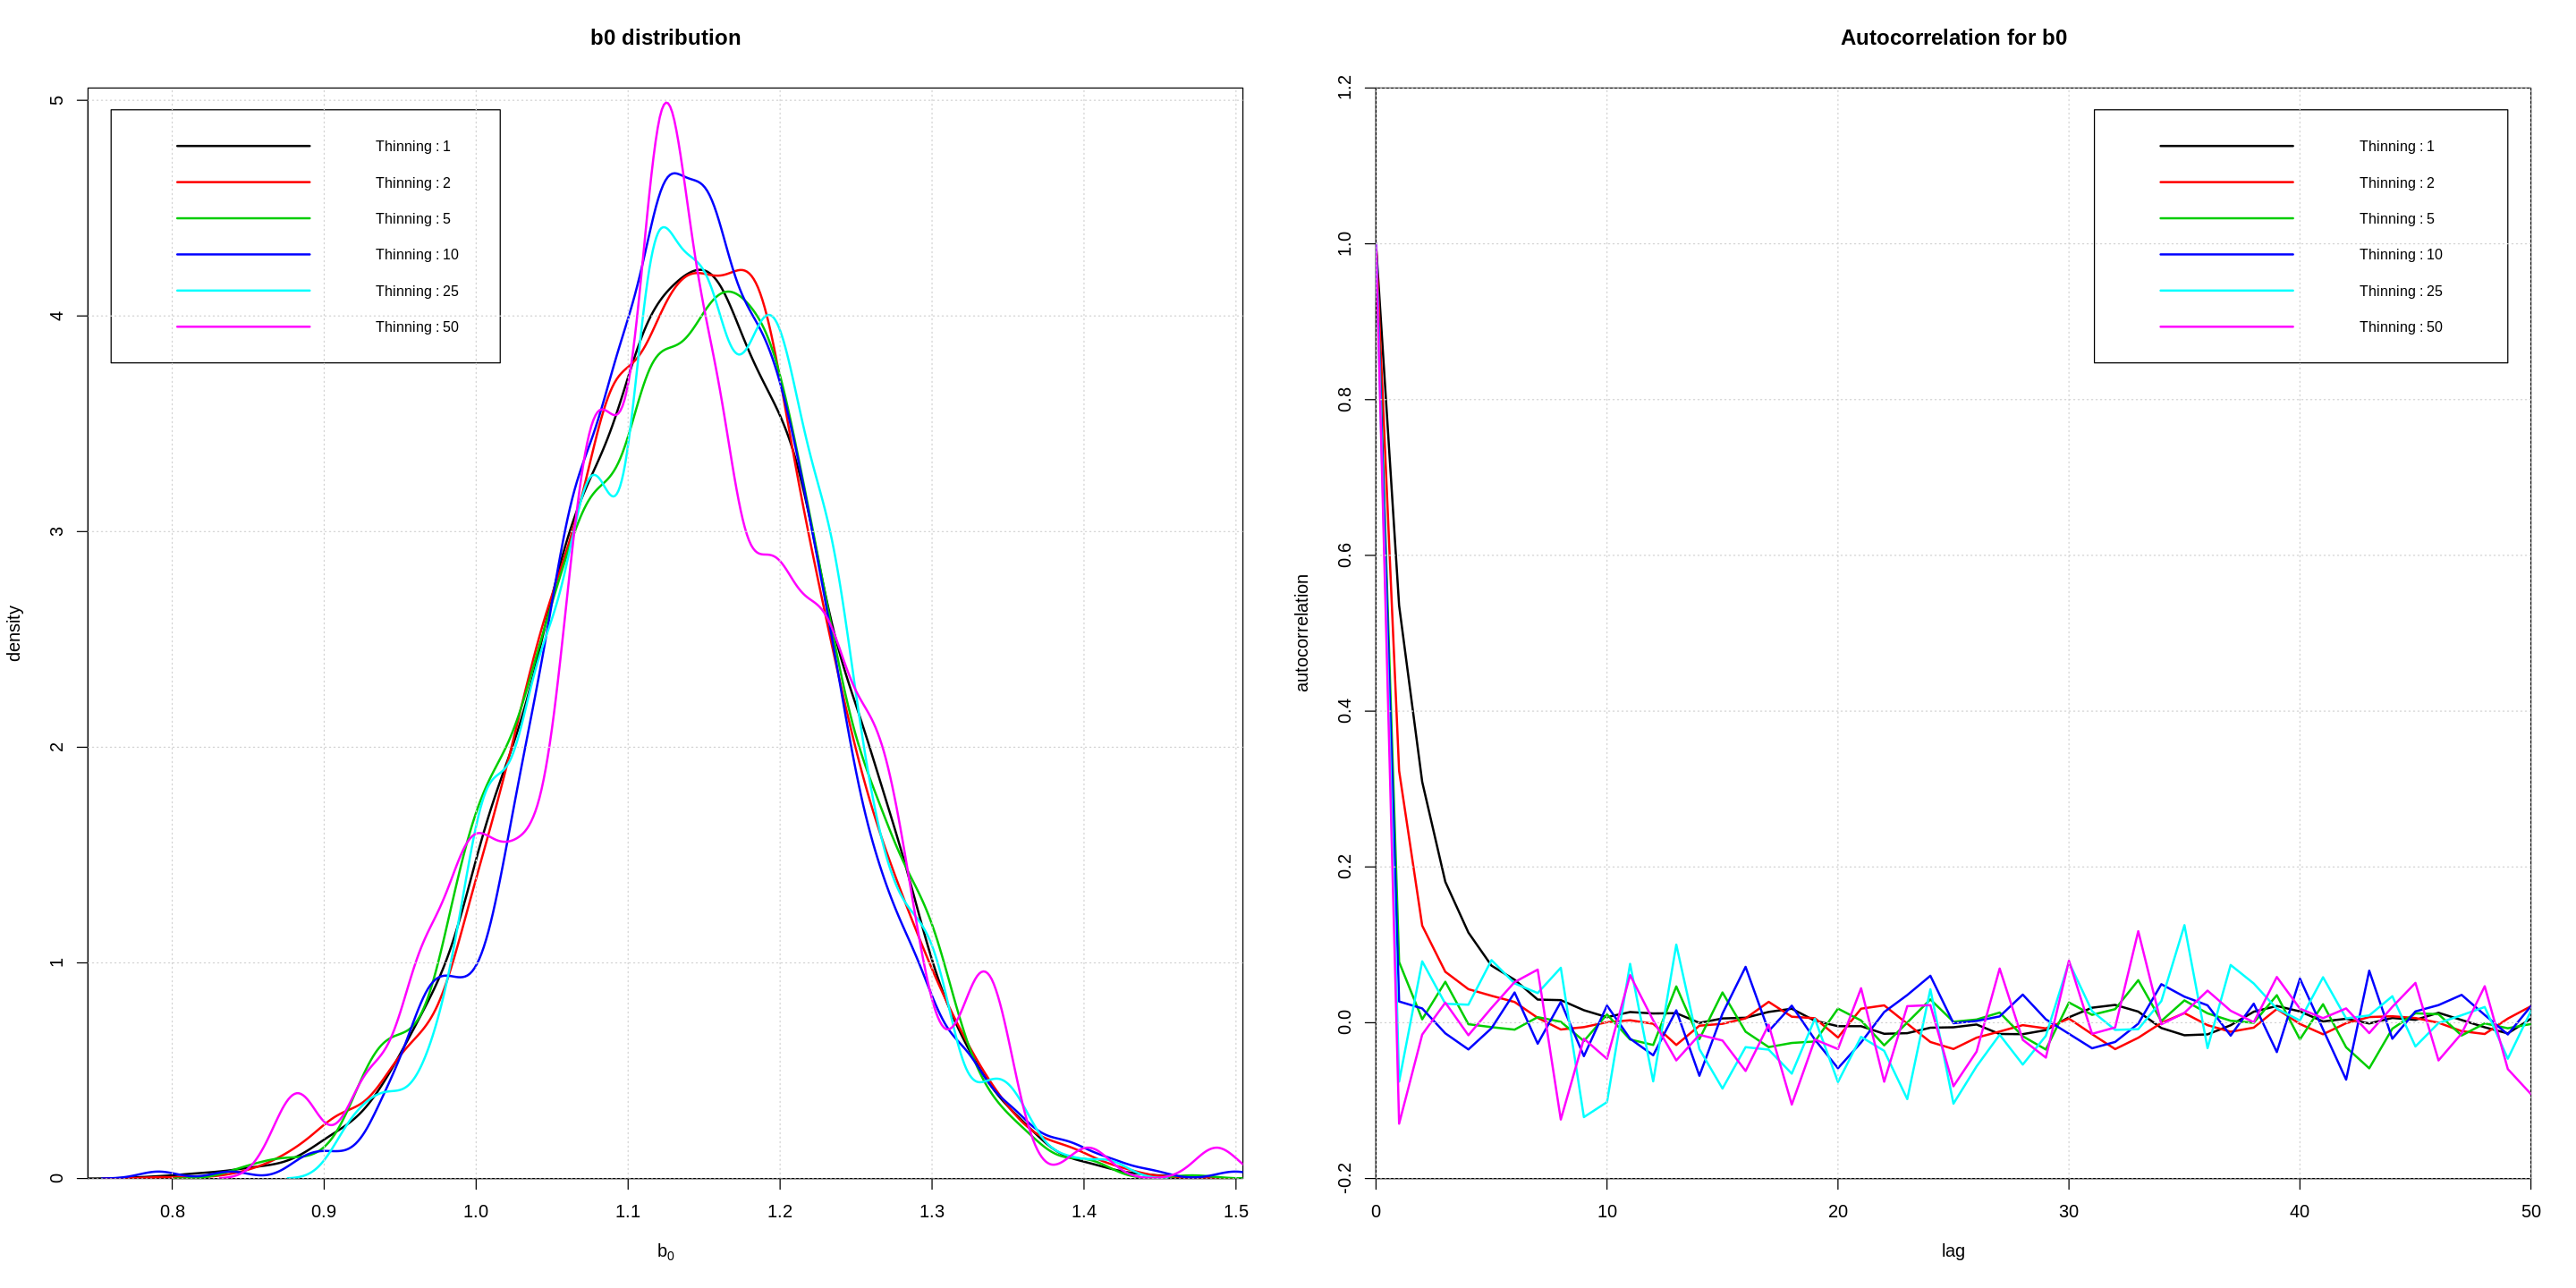

In [60]:
par(mfrow=c(1,2), cex=1)
options(repr.plot.width=24, repr.plot.height=12)
for (i in 1:length(thinnings)) {
    d.b0 <- density(b0.thinnings[,i])
    if (i==1) {
        plot(d.b0$x, d.b0$y,
             xaxs='i', yaxs='i', col=i,
             type='l', lty=1, lwd=2,
             ylim=c(0,1.2*max(d.b0$y)), 
             xlab=expression(b[0]),
             ylab="density")
    } else {
        lines(d.b0$x, d.b0$y,
             col=i, type='l', lty=1, lwd=2)
    }
}
legend("topleft",
       inset=0.02, 
       legend=paste0(rep("Thinning : ", length(thinnings)), as.character(thinnings)),
       col=c(1:length(thinnings)), 
       lty=1:1, 
       cex=0.8,
       text.width=0.06,
       box.lty=1,
       lwd=2)
title("b0 distribution", line=2)
grid()

for (i in 1:length(thinnings)) {
    ac.b0 <- b0.thinnings.ac[,i]
    if (i==1) {
        plot(c(0:50), ac.b0,
             xaxs='i', yaxs='i', col=i,
             type='l', lty=1, lwd=2,
             ylim=c(-0.2,1.2*max(ac.b0)), 
             xlab=expression(lag),
             ylab=expression(autocorrelation))
    } else {
        lines(c(0:50), ac.b0,
             col=i, type='l', lty=1, lwd=2)
    }
}
legend("topright",
       inset=0.02, 
       legend=paste0(rep("Thinning : ", length(thinnings)), as.character(thinnings)),
       col=c(1:length(thinnings)), 
       lty=1:1, 
       cex=0.8,
       text.width=5,
       box.lty=1,
       lwd=2)
title("Autocorrelation for b0", line=2)
grid()

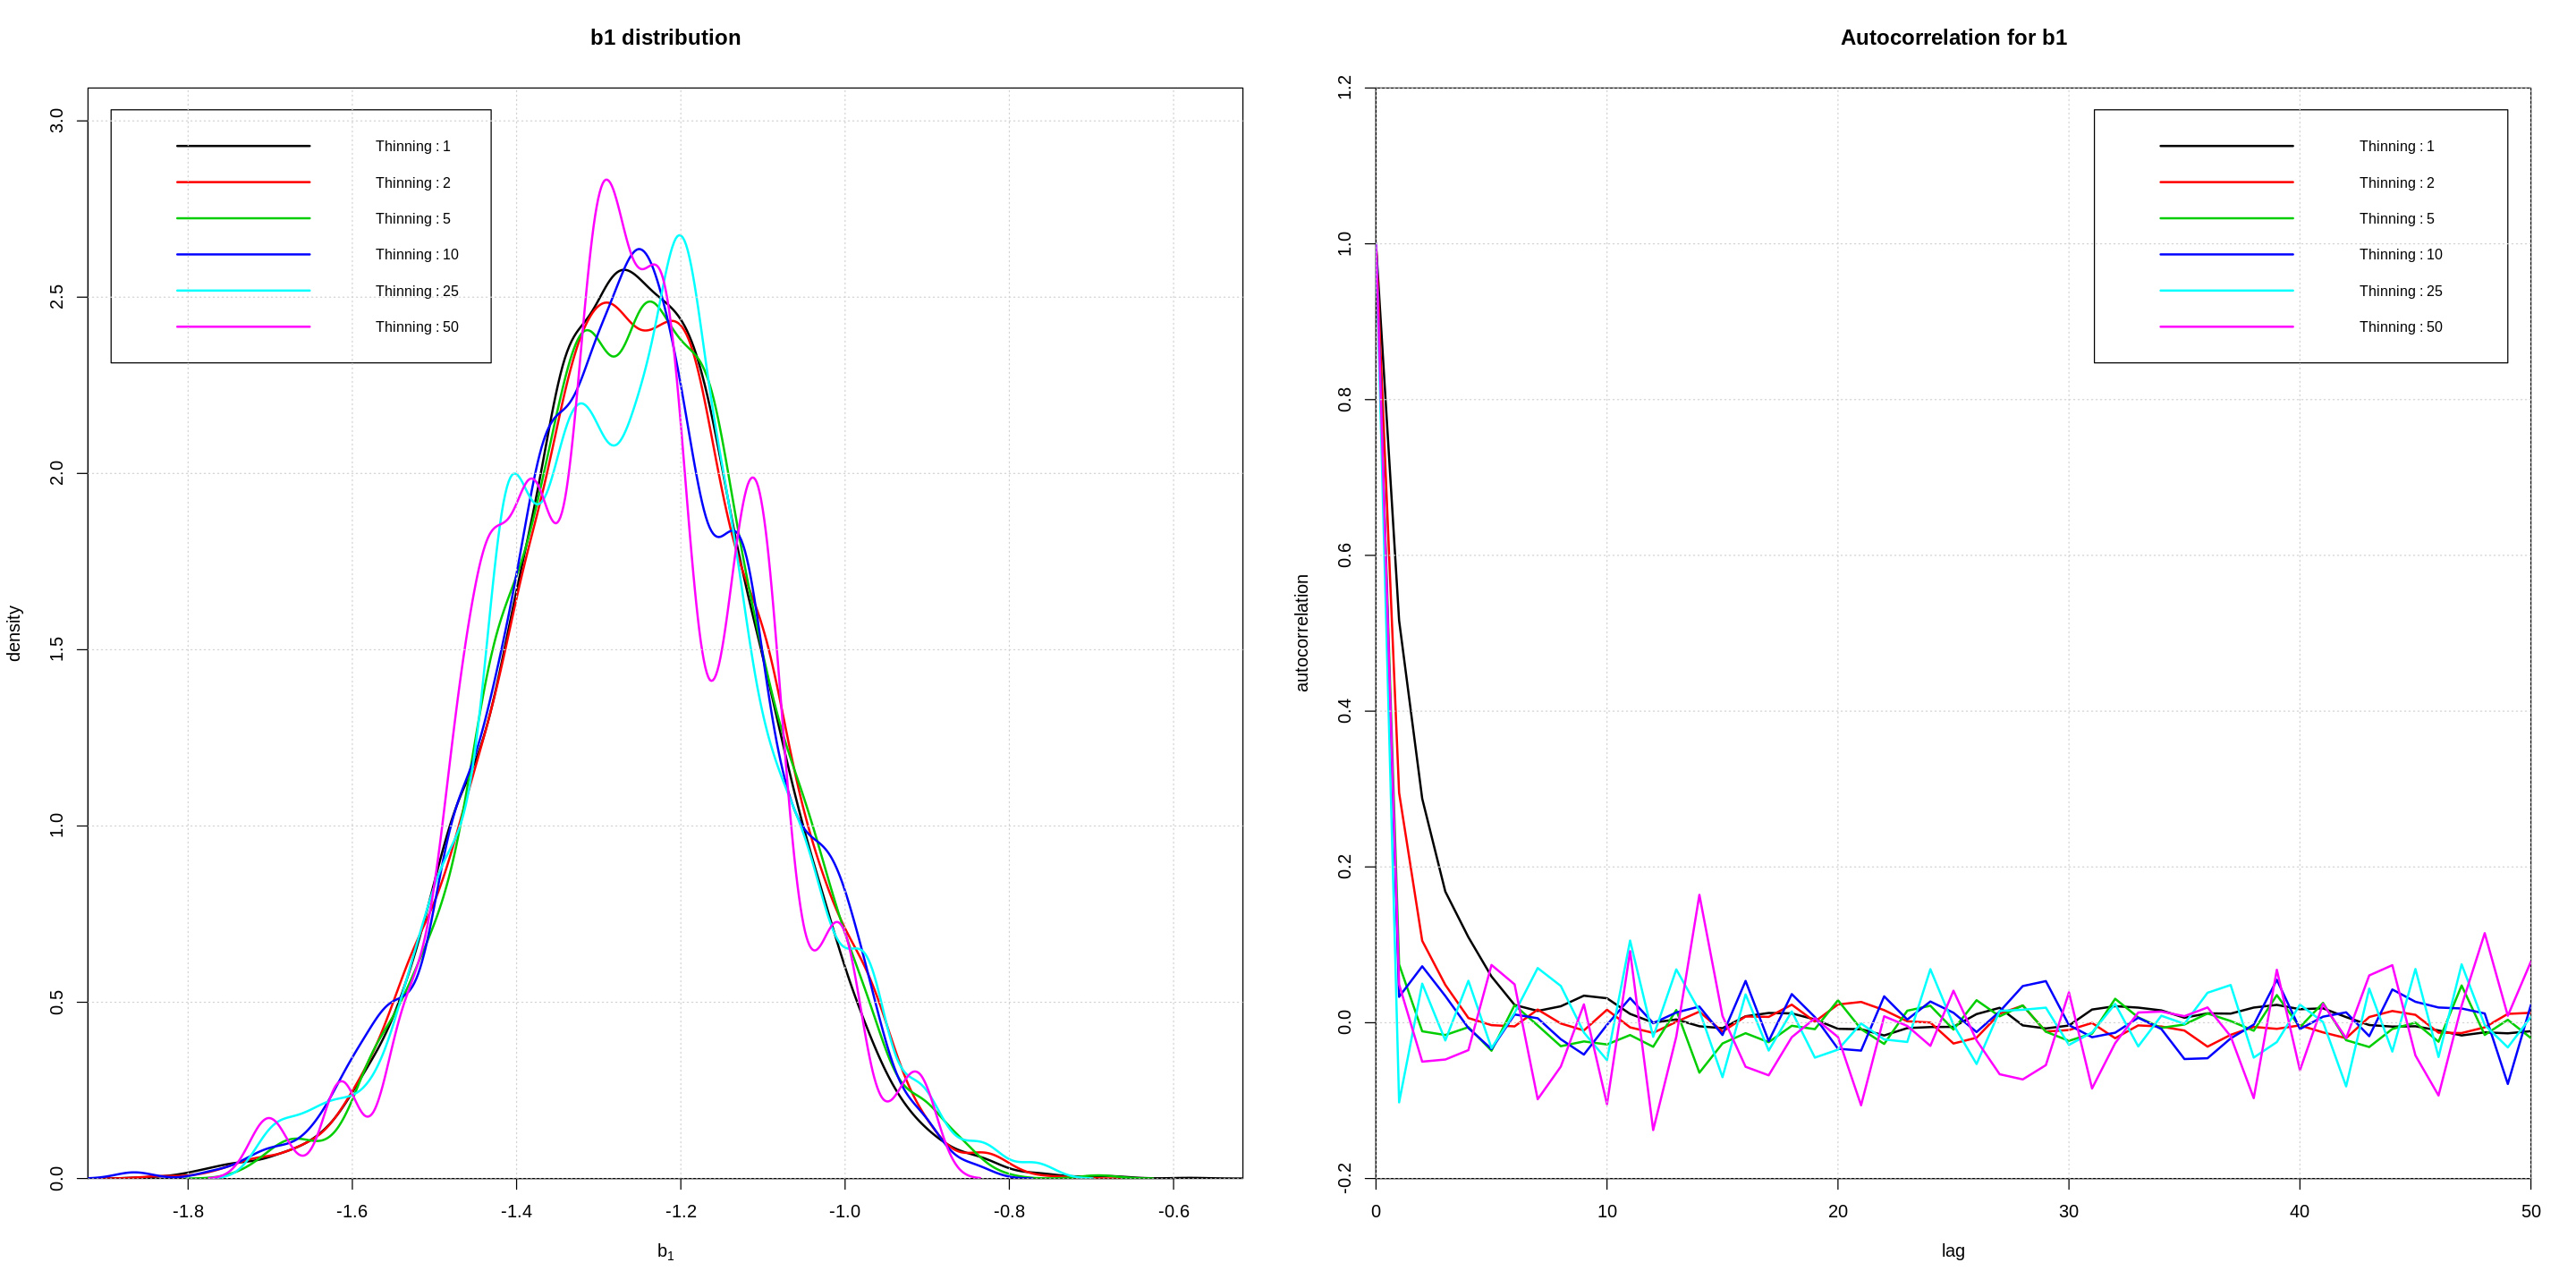

In [61]:
par(mfrow=c(1,2), cex=1)
options(repr.plot.width=24, repr.plot.height=12)
for (i in 1:length(thinnings)) {
    d.b1 <- density(b1.thinnings[,i])
    if (i==1) {
        plot(d.b1$x, d.b1$y,
             xaxs='i', yaxs='i', col=i,
             type='l', lty=1, lwd=2,
             ylim=c(0,1.2*max(d.b1$y)), 
             xlab=expression(b[1]),
             ylab="density")
    } else {
        lines(d.b1$x, d.b1$y,
             col=i, type='l', lty=1, lwd=2)
    }
}
legend("topleft",
       inset=0.02, 
       legend=paste0(rep("Thinning : ", length(thinnings)), as.character(thinnings)),
       col=c(1:length(thinnings)), 
       lty=1:1, 
       cex=0.8,
       text.width=0.1,
       box.lty=1,
       lwd=2)
title("b1 distribution", line=2)
grid()

for (i in 1:length(thinnings)) {
    ac.b1 <- b1.thinnings.ac[,i]
    if (i==1) {
        plot(c(0:50), ac.b1,
             xaxs='i', yaxs='i', col=i,
             type='l', lty=1, lwd=2,
             ylim=c(-0.2,1.2*max(ac.b1)), 
             xlab=expression(lag),
             ylab=expression(autocorrelation))
    } else {
        lines(c(0:50), ac.b1,
             col=i, type='l', lty=1, lwd=2)
    }
}
legend("topright",
       inset=0.02, 
       legend=paste0(rep("Thinning : ", length(thinnings)), as.character(thinnings)),
       col=c(1:length(thinnings)), 
       lty=1:1, 
       cex=0.8,
       text.width=5,
       box.lty=1,
       lwd=2)
title("Autocorrelation for b1", line=2)
grid()

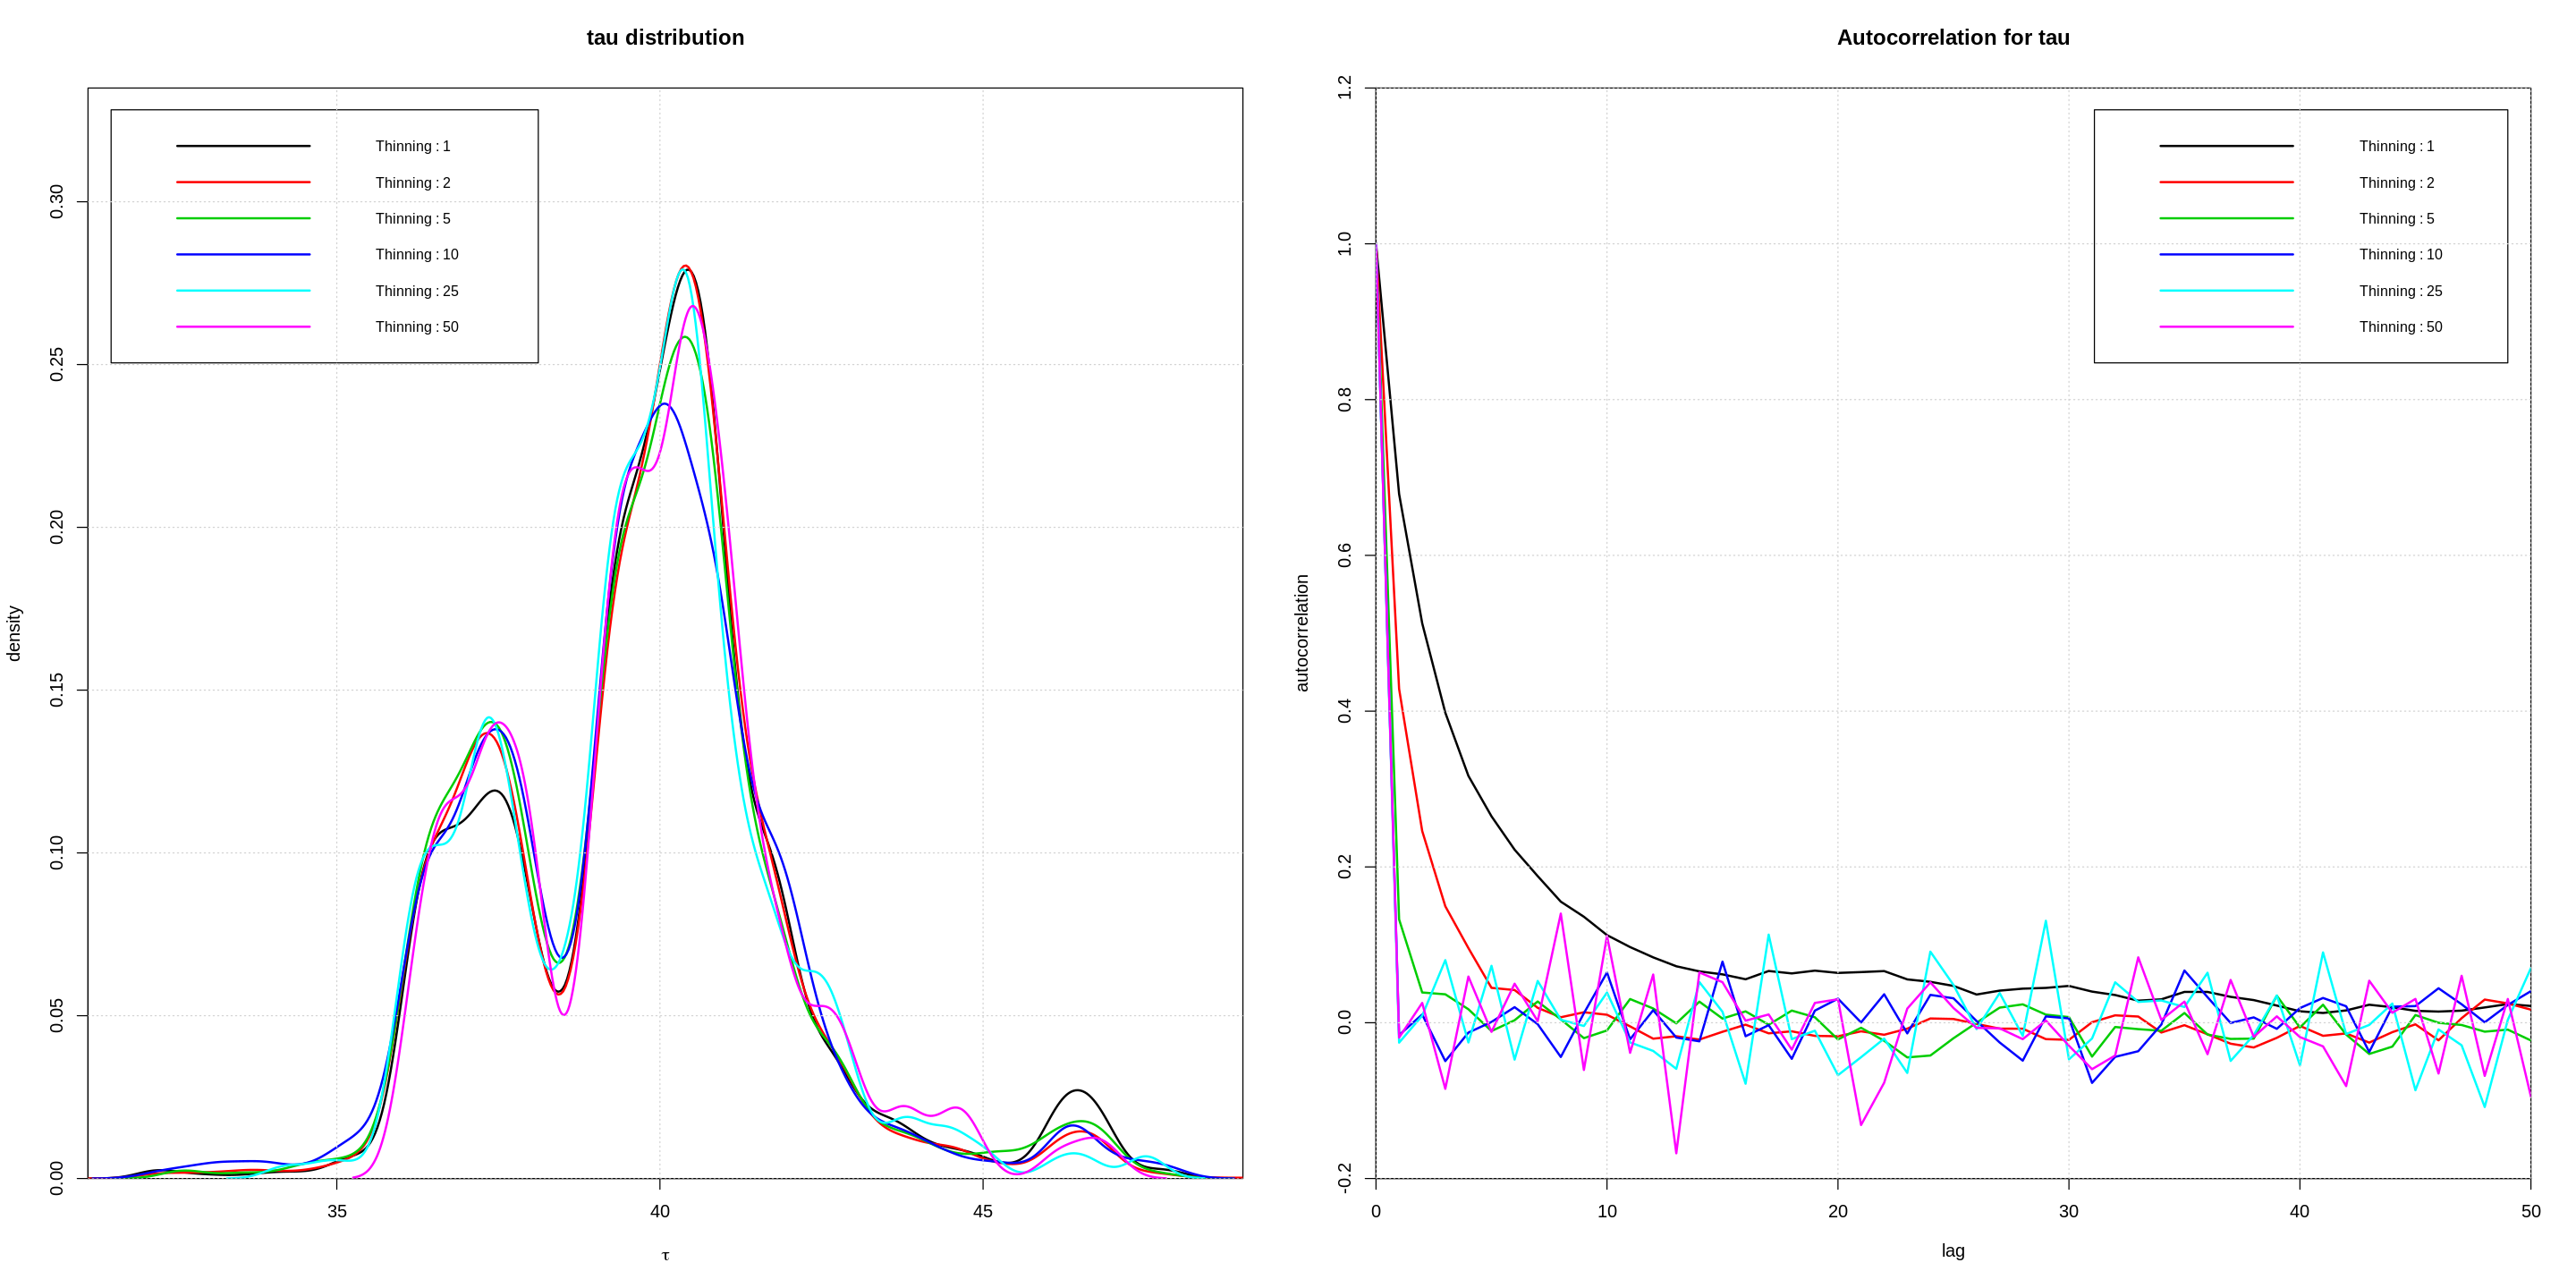

In [62]:
par(mfrow=c(1,2), cex=1)
options(repr.plot.width=24, repr.plot.height=12)
for (i in 1:length(thinnings)) {
    d.tau <- density(tau.thinnings[,i])
    if (i==1) {
        plot(d.tau$x, d.tau$y,
             xaxs='i', yaxs='i', col=i,
             type='l', lty=1, lwd=2,
             ylim=c(0,1.2*max(d.tau$y)), 
             xlab=expression(tau),
             ylab="density")
    } else {
        lines(d.tau$x, d.tau$y,
             col=i, type='l', lty=1, lwd=2)
    }
}
legend("topleft",
       inset=0.02, 
       legend=paste0(rep("Thinning : ", length(thinnings)), as.character(thinnings)),
       col=c(1:length(thinnings)), 
       lty=1:1, 
       cex=0.8,
       text.width=2,
       box.lty=1,
       lwd=2)
title("tau distribution", line=2)
grid()

for (i in 1:length(thinnings)) {
    #x <- c(1:length(b0.burn.in[,i]))
    ac.tau <- tau.thinnings.ac[,i]
    if (i==1) {
        plot(c(0:50), ac.tau,
             xaxs='i', yaxs='i', col=i,
             type='l', lty=1, lwd=2,
             #ylim=c(0,2),
             ylim=c(-0.2,1.2*max(ac.tau)), 
             xlab=expression(lag),
             ylab=expression(autocorrelation))
    } else {
        lines(c(0:50), ac.tau,
             col=i, type='l', lty=1, lwd=2)
    }
}
legend("topright",
       inset=0.02, 
       legend=paste0(rep("Thinning : ", length(thinnings)), as.character(thinnings)),
       col=c(1:length(thinnings)), 
       lty=1:1, 
       cex=0.8,
       text.width=5,
       box.lty=1,
       lwd=2)
title("Autocorrelation for tau", line=2)
grid()

**As we can see from the plots in the cells above, increasing the thinning make the autocorrelation function becomes smaller in a minor number of the lag value. However, this trend is true until an optimal value (~5-10) is reached. After this value, the autocorrelation starts to oscillate and the distribution of the parameters becomes less smooth.**

### 2.3. - Plot of the posterior distributions of the parameters, mean values and 95% credibility interval <a class="anchor" id="Ex2.3."></a>

**Let's consider again the first case analyzed (burn-in of $1000$ and thinning of $1$).**

In [63]:
model <- "BUGS_model.bug"

# initialize parameters
init.par     <- NULL
init.par$b0  <- 0
init.par$b1  <- 0
init.par$tau <- 50

# initialize BUGS model with a certain burn in
jags.m  <- jags.model(model, data, init.par, n.adapt=0)

# Update the Markov chain (Burn-in)
update(jags.m, 1000)

# run BUGS model
chain.0 <- coda.samples(jags.m , c("b0", "b1","tau"), n.iter=10000, thin=1)

# convert to data.frame
chain.0.df <- as.data.frame(as.mcmc(chain.0))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 115
   Total graph size: 901

Initializing model

NOTE: Stopping adaptation




In [64]:
b0.data  <- density(chain.0.df[[1]])
b1.data  <- density(chain.0.df[[2]])
tau.data <- density(chain.0.df[[3]])

In [65]:
b0.x  <- b0.data$x
b1.x  <- b1.data$x
tau.x <- tau.data$x

b0.d  <- b0.data$y
b1.d  <- b1.data$y
tau.d <- tau.data$y

**Posterior mean and variance**

In [66]:
b0.mean  <- compute.mean(b0.x,  b0.d)
b1.mean  <- compute.mean(b1.x,  b1.d)
tau.mean <- compute.mean(tau.x, tau.d)

b0.var  <- compute.var(b0.x,  b0.d)
b1.var  <- compute.var(b1.x,  b1.d)
tau.var <- compute.var(tau.x, tau.d)

b0.sd  <- sqrt(b0.var)
b1.sd  <- sqrt(b1.var)
tau.sd <- sqrt(tau.var)

In [67]:
cat("********** RESULTS FOR b0 **********", "\n")
cat("b0 posterior mean    :", b0.mean, "\n")
cat("b0 posterior variance:", b0.var,  "\n")
cat("b0 posterior s.d.    :", b0.sd, "\n\n")

cat("********** RESULTS FOR b1 **********", "\n")
cat("b1 posterior mean    :", b1.mean, "\n")
cat("b1 posterior variance:", b1.var,  "\n")
cat("b1 posterior s.d.    :", b1.sd, "\n\n")

cat("********** RESULTS FOR tau **********", "\n")
cat("tau posterior mean    :", tau.mean, "\n")
cat("tau posterior variance:", tau.var,  "\n")
cat("tau posterior s.d.    :", tau.sd)

********** RESULTS FOR b0 ********** 
b0 posterior mean    : 1.139709 
b0 posterior variance: 0.009267504 
b0 posterior s.d.    : 0.09626787 

********** RESULTS FOR b1 ********** 
b1 posterior mean    : -1.261821 
b1 posterior variance: 0.02462028 
b1 posterior s.d.    : 0.1569085 

********** RESULTS FOR tau ********** 
tau posterior mean    : 39.78255 
tau posterior variance: 4.752984 
tau posterior s.d.    : 2.180134

**95% credibility interval**

In [68]:
b0.m  <- get.x.dmax(b0.x,  b0.d)
b1.m  <- get.x.dmax(b1.x,  b1.d)
tau.m <- get.x.dmax(tau.x, tau.d)

b0.c  <- get.c.int(b0.x,  b0.d)
b1.c  <- get.c.int(b1.x,  b1.d)
tau.c <- get.c.int(tau.x, tau.d)

In [69]:
cat("********** RESULTS FOR b0 **********", "\n")
cat("b0 most probable value     :", b0.mean, "\n")
cat("b0 95% credibility interval: [", b0.c[1], " ", b0.c[2], "]", "\n\n", sep="")

cat("********** RESULTS FOR b1 **********", "\n")
cat("b1 most probable value     :", b1.mean, "\n")
cat("b1 95% credibility interval: [", b1.c[1], " ", b1.c[2], "]", "\n\n", sep="")

cat("********** RESULTS FOR tau **********", "\n")
cat("tau most probable value     :", tau.mean, "\n")
cat("tau 95% credibility interval: [", tau.c[1], " ", tau.c[2], "]", sep="")

********** RESULTS FOR b0 ********** 
b0 most probable value     : 1.139709 
b0 95% credibility interval: [0.9461581 1.319665]

********** RESULTS FOR b1 ********** 
b1 most probable value     : -1.261821 
b1 95% credibility interval: [-1.574517 -0.9619677]

********** RESULTS FOR tau ********** 
tau most probable value     : 39.78255 
tau 95% credibility interval: [36.02974 44.82746]

**Plot the posterior distributions of the parameters with 95% credibility interval**

In [70]:
# code for polygon function
b0.xs  <-  b0.x[ b0.x>= b0.c[1] &  b0.x<= b0.c[2]]
b1.xs  <-  b1.x[ b1.x>= b1.c[1] &  b1.x<= b1.c[2]]
tau.xs <- tau.x[tau.x>=tau.c[1] & tau.x<=tau.c[2]]

b0.ys  <-  b0.d[ b0.x>= b0.c[1] &  b0.x<= b0.c[2]]
b1.ys  <-  b1.d[ b1.x>= b1.c[1] &  b1.x<= b1.c[2]]
tau.ys <- tau.d[tau.x>=tau.c[1] & tau.x<=tau.c[2]]

b0.xs.c1.i1  <- tail(which( b0.x<= b0.c[1]), n=1)
b1.xs.c1.i1  <- tail(which( b1.x<= b1.c[1]), n=1)
tau.xs.c1.i1 <- tail(which(tau.x<=tau.c[1]), n=1)

b0.xs.c2.i1  <- tail(which( b0.x<= b0.c[2]), n=1)
b1.xs.c2.i1  <- tail(which( b1.x<= b1.c[2]), n=1)
tau.xs.c2.i1 <- tail(which(tau.x<=tau.c[2]), n=1)

b0.ys.c1  <-  b0.d[ b0.xs.c1.i1] + ( b0.d[ b0.xs.c1.i1+1] -  b0.d[ b0.xs.c1.i1])/( b0.x[ b0.xs.c1.i1+1] -  b0.x[ b0.xs.c1.i1]) * ( b0.c[1] -  b0.x[ b0.xs.c1.i1])
b1.ys.c1  <-  b1.d[ b1.xs.c1.i1] + ( b1.d[ b1.xs.c1.i1+1] -  b1.d[ b1.xs.c1.i1])/( b1.x[ b1.xs.c1.i1+1] -  b1.x[ b1.xs.c1.i1]) * ( b1.c[1] -  b1.x[ b1.xs.c1.i1])
tau.ys.c1 <- tau.d[tau.xs.c1.i1] + (tau.d[tau.xs.c1.i1+1] - tau.d[tau.xs.c1.i1])/(tau.x[tau.xs.c1.i1+1] - tau.x[tau.xs.c1.i1]) * (tau.c[1] - tau.x[tau.xs.c1.i1])

b0.ys.c2  <-  b0.d[ b0.xs.c2.i1] + ( b0.d[ b0.xs.c2.i1+1] -  b0.d[ b0.xs.c2.i1])/( b0.x[ b0.xs.c2.i1+1] -  b0.x[ b0.xs.c2.i1]) * ( b0.c[2] -  b0.x[ b0.xs.c2.i1])
b1.ys.c2  <-  b1.d[ b1.xs.c2.i1] + ( b1.d[ b1.xs.c2.i1+1] -  b1.d[ b1.xs.c2.i1])/( b1.x[ b1.xs.c2.i1+1] -  b1.x[ b1.xs.c2.i1]) * ( b1.c[2] -  b1.x[ b1.xs.c2.i1])
tau.ys.c2 <- tau.d[tau.xs.c2.i1] + (tau.d[tau.xs.c2.i1+1] - tau.d[tau.xs.c2.i1])/(tau.x[tau.xs.c2.i1+1] - tau.x[tau.xs.c2.i1]) * (tau.c[2] - tau.x[tau.xs.c2.i1])

b0.xs  <- c( b0.c[1],  b0.c[1],  b0.xs,  b0.c[2],  b0.c[2])
b1.xs  <- c( b1.c[1],  b1.c[1],  b1.xs,  b1.c[2],  b1.c[2])
tau.xs <- c(tau.c[1], tau.c[1], tau.xs, tau.c[2], tau.c[2])

b0.ys  <- c(0,  b0.ys.c1,  b0.ys,  b0.ys.c2, 0)
b1.ys  <- c(0,  b1.ys.c1,  b1.ys,  b1.ys.c2, 0)
tau.ys <- c(0, tau.ys.c1, tau.ys, tau.ys.c2, 0)

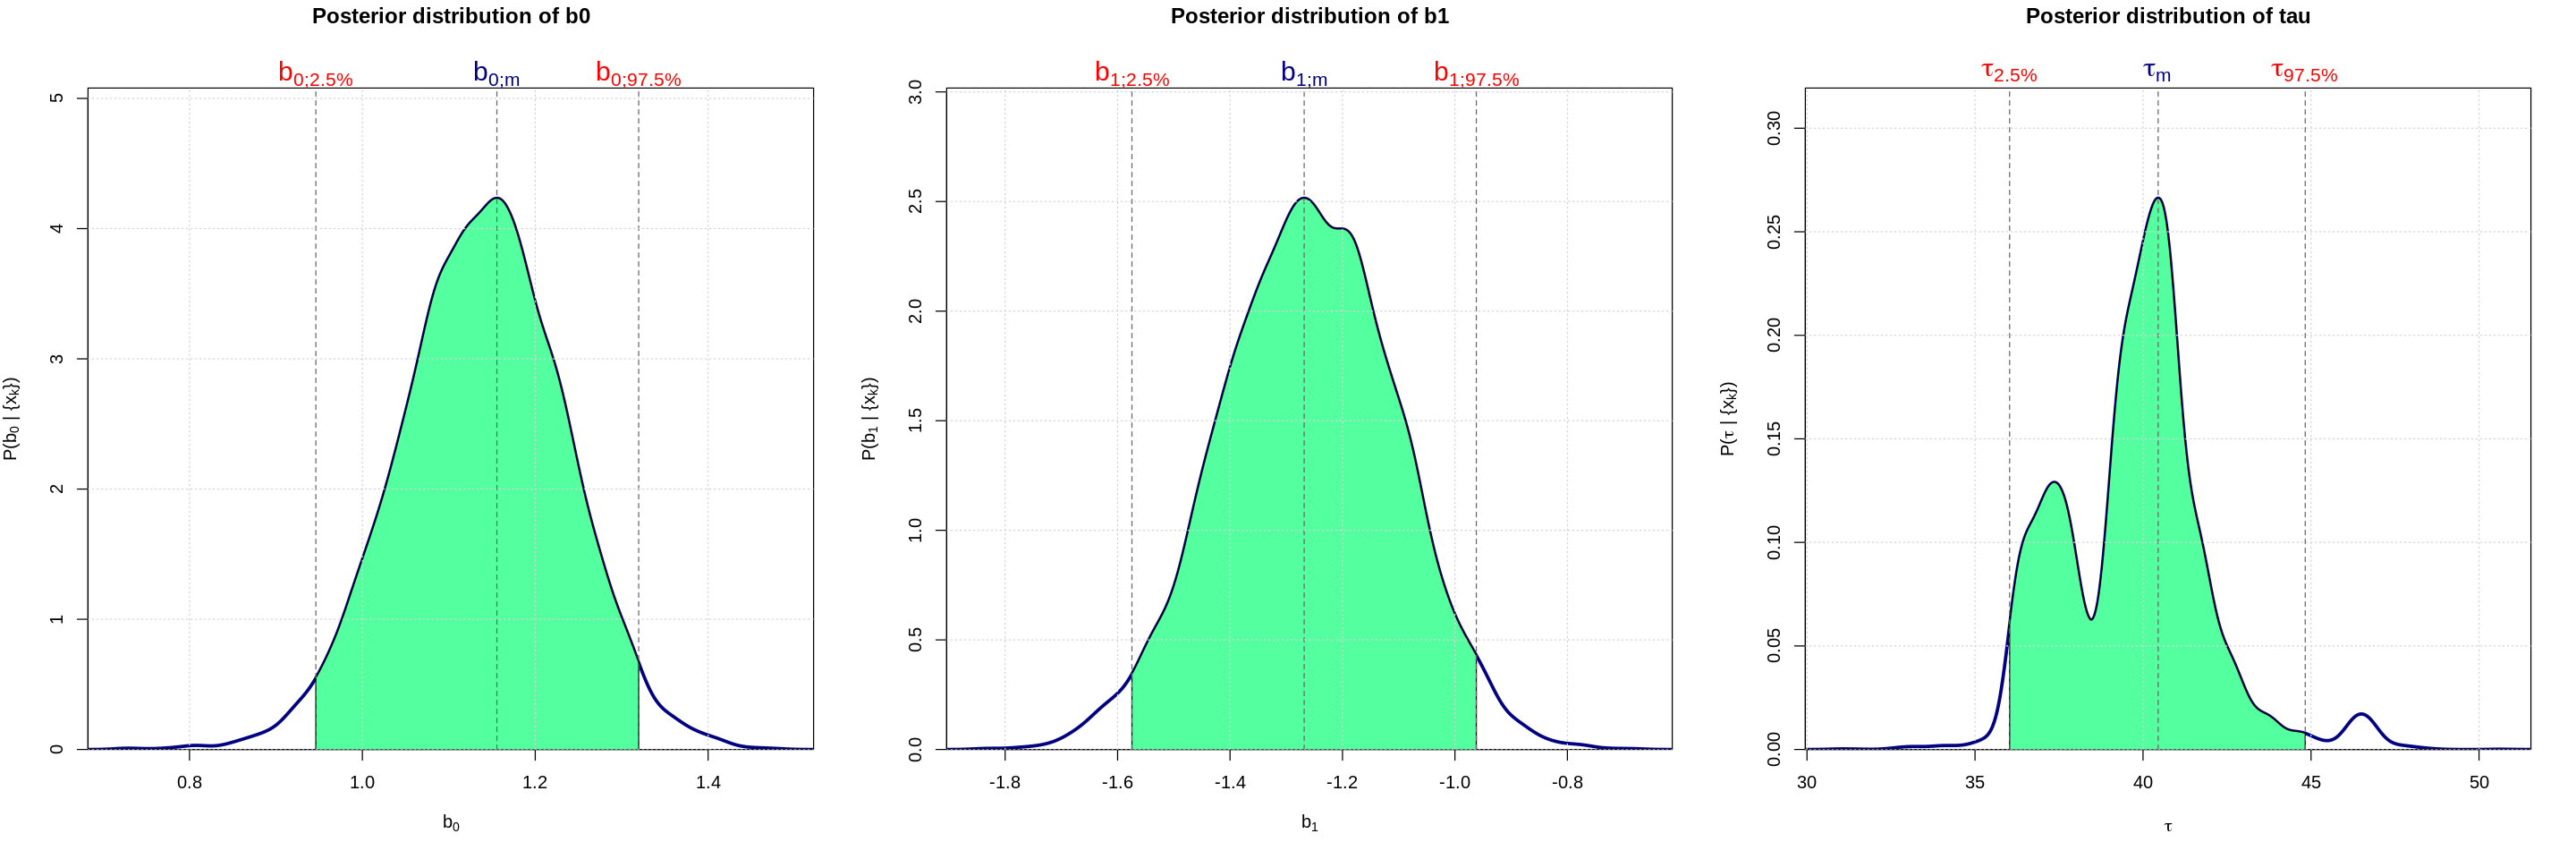

In [71]:
par(mfrow=c(1,3), cex=1)
options(repr.plot.width=24, repr.plot.height=8)

plot(b0.x, b0.d, 
     xaxs='i', yaxs='i', col='navy', 
     type='l', lty=1, lwd=3,
     ylim=c(0,1.2*max(b0.d)), 
     xlab=expression(b[0]),
     ylab=expression(paste("P","(", b[0], " | {x"[k],"})")))
polygon(x=b0.xs, y=b0.ys, col='seagreen1')
abline(v=b0.c[1], col="grey40", lty=2)
abline(v=b0.c[2], col="grey40", lty=2)
abline(v=b0.m,    col="grey40", lty=2)
text(b0.c[1], 1.05*par("usr")[4], labels=expression(b[0][";2.5%"]),  pos=1, cex=1.5, col="red",  xpd=TRUE)
text(b0.c[2], 1.05*par("usr")[4], labels=expression(b[0][";97.5%"]), pos=1, cex=1.5, col="red",  xpd=TRUE)
text(b0.m,    1.05*par("usr")[4], labels=expression(b[0][";m"]),     pos=1, cex=1.5, col="navy", xpd=TRUE)
title("Posterior distribution of b0", line=3)
grid()

plot(b1.x, b1.d, 
     xaxs='i', yaxs='i', col='navy', 
     type='l', lty=1, lwd=3,
     ylim=c(0,1.2*max(b1.d)), 
     xlab=expression(b[1]),
     ylab=expression(paste("P","(", b[1], " | {x"[k],"})")))
polygon(x=b1.xs, y=b1.ys, col='seagreen1')
abline(v=b1.c[1], col="grey40", lty=2)
abline(v=b1.c[2], col="grey40", lty=2)
abline(v=b1.m,    col="grey40", lty=2)
text(b1.c[1], 1.05*par("usr")[4], labels=expression(b[1][";2.5%"]),  pos=1, cex=1.5, col="red",  xpd=TRUE)
text(b1.c[2], 1.05*par("usr")[4], labels=expression(b[1][";97.5%"]), pos=1, cex=1.5, col="red",  xpd=TRUE)
text(b1.m,    1.05*par("usr")[4], labels=expression(b[1][";m"]),     pos=1, cex=1.5, col="navy", xpd=TRUE)
title("Posterior distribution of b1", line=3)
grid()

plot(tau.x, tau.d, 
     xaxs='i', yaxs='i', col='navy', 
     type='l', lty=1, lwd=3,
     ylim=c(0,1.2*max(tau.d)), 
     xlab=expression(tau),
     ylab=expression(paste("P","(", tau, " | {x"[k],"})")))
polygon(x=tau.xs, y=tau.ys, col='seagreen1')
abline(v=tau.c[1], col="grey40", lty=2)
abline(v=tau.c[2], col="grey40", lty=2)
abline(v=tau.m,    col="grey40", lty=2)
text(tau.c[1], 1.05*par("usr")[4], labels=expression(tau["2.5%"]),  pos=1, cex=1.5, col="red",  xpd=TRUE)
text(tau.c[2], 1.05*par("usr")[4], labels=expression(tau["97.5%"]), pos=1, cex=1.5, col="red",  xpd=TRUE)
text(tau.m,    1.05*par("usr")[4], labels=expression(tau["m"]),     pos=1, cex=1.5, col="navy", xpd=TRUE)
title("Posterior distribution of tau", line=3)
grid()